Your patient comes in. They're having a stinging pain in the chest. The X-Ray shows a shadow on the lung. And that shadow is air. If not treated a "collapsed lung"(-ish), or "air on the wrong side of the lung", can result in death.

[What's a Pneumothorax?](https://en.wikipedia.org/wiki/Pneumothorax)

Problem is in an X-Ray, air is usually the thing you ignore. The general idea is:

- Black: Air
- Gray: Fluids and Tissue
- White: Bone and Solids

So the issue is that an air enclosure may just be a mild disturbance in the chest xray. Considering convolutional neural networks are exceptional at identifying abnormalities, we may want them to take a look, as not to miss these tiny abnormalities.


![Futuristic view of human](https://www.publicdomainpictures.net/pictures/50000/nahled/anatomy-high-tech.jpg)

In this challenge, we get chest xrays and masks. In challenges I link below, only bounding boxes were available. Here, we actually get to do dense prediction.

I'm hiding some cells for readability below, just fork the kernel or click the "Show code" on the right to see imports etc. This kernel is just giving some starting info and how to look at the data with the given tools. 

Sources I used and further reading:

- https://www.kaggle.com/c/rsna-pneumonia-detection-challenge
- https://www.kaggle.com/schlerp/getting-to-know-dicom-and-the-data/data

Some ideas that might be helpful:

- [Check out Pneumonia X-Ray Challenge](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge)
- [Use TFRecords](https://www.kaggle.com/lyonzy/convert-dicom-images-to-tfrecords)
- [Check Out Unets](https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics)

In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import glob

import pydicom
import cv2

#print(os.listdir("../input/siim-acr-pneumothorax-segmentation"))
#print()
#print(os.listdir("../input/siim-acr-pneumothorax-segmentation/sample images"))
# Any results you write to the current directory are saved as output.

from matplotlib import cm
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import ModelCheckpoint

import tensorflow as tf

#from tqdm import tqdm_notebook

import sys
#sys.path.insert(0, '../input/siim-acr-pneumothorax-segmentation')

from mask_functions import rle2mask, mask2rle

## What is DICOM?

Dicom is a format that has metadata, as well as Pixeldata attached to it. Below I extract some basic info with an image. You will know about the gender and age of the patient, as well as info how the image is sampled and generated. Quite useful to programatically read. Here's the [Wikipedia](https://en.wikipedia.org/wiki/DICOM) article for it.

In [2]:
def show_dcm_info(dataset):
    print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()


Let's first take a look at the sample images that are available. You'll be able to transfer this kernel to downloaded data, to visualize other bits and explore their metadata.

Filename.........: ../data/sample images\1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 17d405a3-a0d2-4901-b33a-63906aa48d9f, 
Patient id..........: 17d405a3-a0d2-4901-b33a-63906aa48d9f
Patient's Age.......: 38
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 130476 bytes
Pixel spacing....: ['0.168', '0.168']


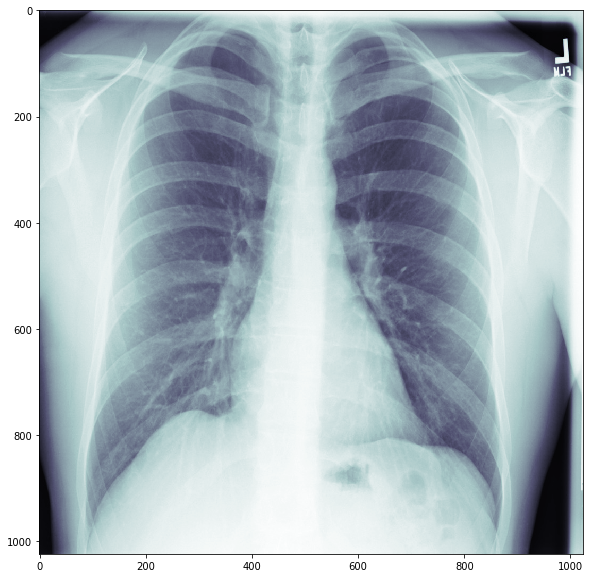

In [3]:
for file_path in glob.glob('../data/sample images/*.dcm'):
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    plot_pixel_array(dataset)
    break # Comment this out to see all

## How do the masks look like?

First let's look at all the sample images. We can see different modes of collection. It becomes very evident, that we have to be careful about the top right marker on the image. The different L may mess with our data. Could it be usable leakage as it points to the hospital it was taken at? Yes, yes it could, but I'm *sure* Kaggle took care of this.

Then we'll look at 3 images and the masks that come with it. Personally, I can't really make out how to find the pneumothorax in the images. Play around with it, in some of the other images, it is definitely more visible than in others. Also (thanks to Ehsan) make sure to transpose the masks!

In [4]:
num_img = len(glob.glob('../data/sample images/*.dcm'))
fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for q, file_path in enumerate(glob.glob('../data/sample images/*.dcm')):
    dataset = pydicom.dcmread(file_path)
    #show_dcm_info(dataset)
    
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


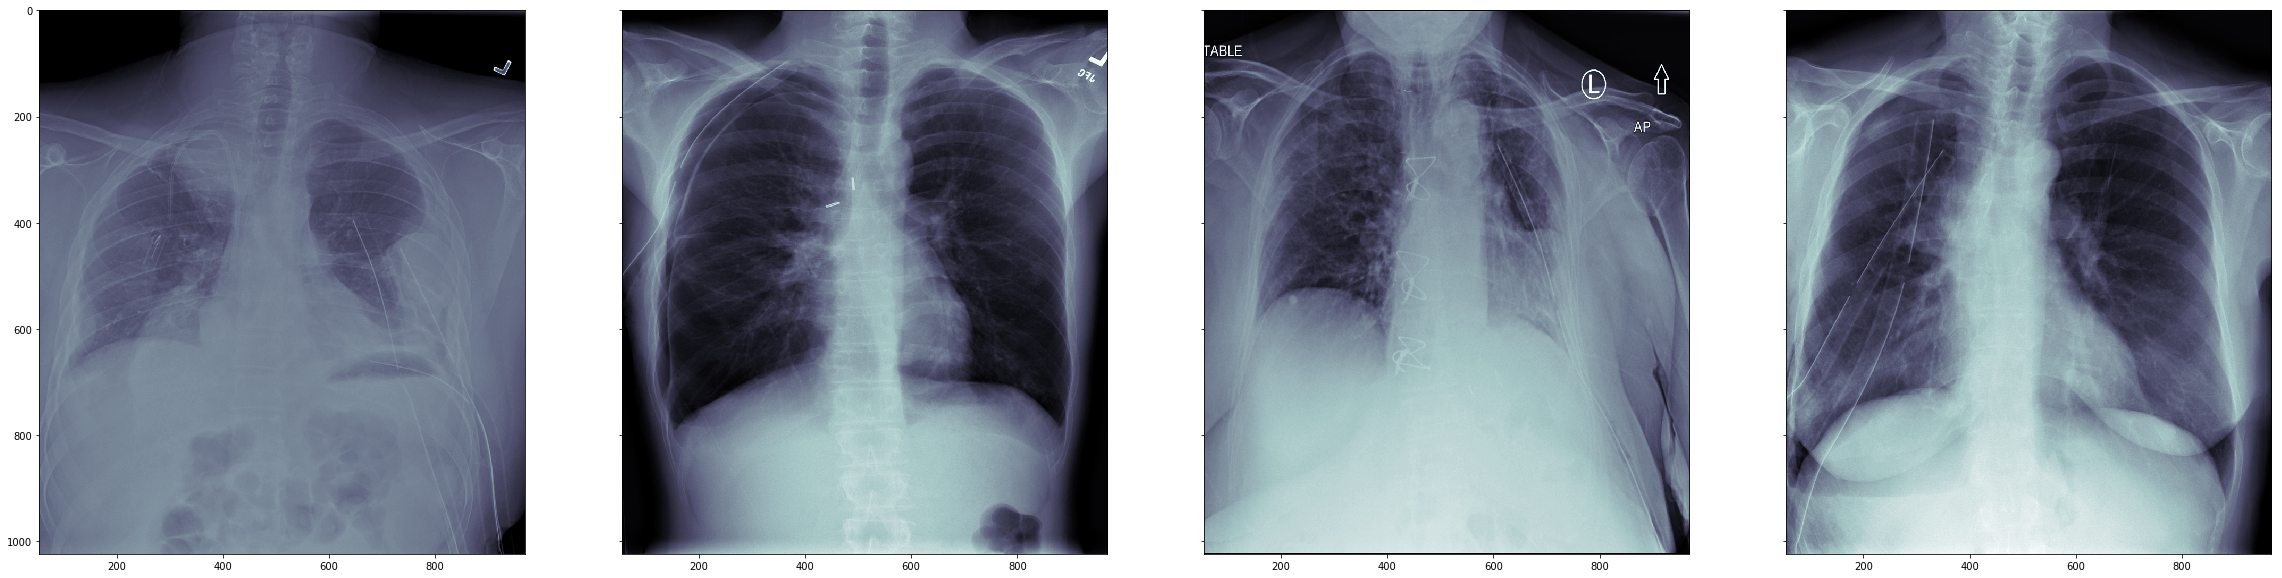

In [5]:
start = 5   # Starting index of images
num_img = 4 # Total number of images to show

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for q, file_path in enumerate(glob.glob('../data/sample images/*.dcm')[start:start+num_img]):
    dataset = pydicom.dcmread(file_path)
    #show_dcm_info(dataset)
    
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.show()

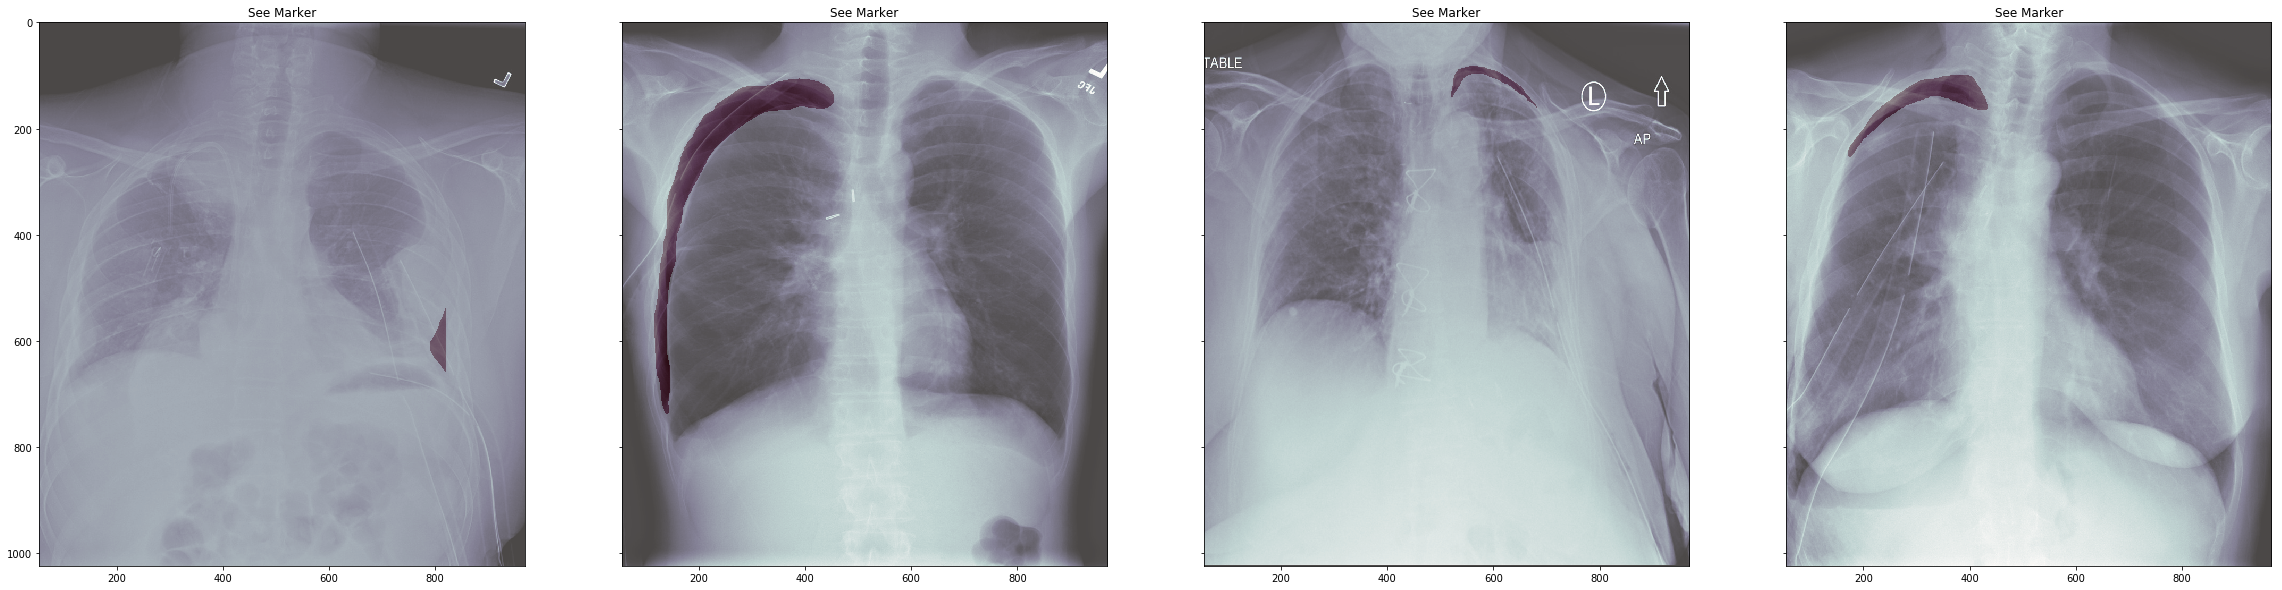

In [6]:
df = pd.read_csv('../data/sample images/train-rle-sample.csv', header=None, index_col=0)

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for q, file_path in enumerate(glob.glob('../data/sample images/*.dcm')[start:start+num_img]):
    file_path = file_path.replace('\\', '/')
    dataset = pydicom.dcmread(file_path)
    #print(file_path.split('/')[-1][:-4])
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    if df.loc[file_path.split('/')[-1][:-4],1] != '-1':
        mask = rle2mask(df.loc[file_path.split('/')[-1][:-4],1], 1024, 1024).T
        ax[q].set_title('See Marker')
        ax[q].imshow(mask, alpha=0.3, cmap="Reds")
    else:
        ax[q].set_title('Nothing to see')
plt.show()

## Vanilla Unet
So how would we work the data on GCP?

I'd suggest a very nice [Unet](https://arxiv.org/abs/1505.04597), maybe use a pretty pre-trained encoder instead of the following. They're excellent on small-ish datasets and particularly on image segmentation. There are many others you may try, but maybe this one will get you started.

![](http://deeplearning.net/tutorial/_images/unet.jpg)

### Load Full Dataset

In [7]:
train_glob = '../data/dicom-images-train/*/*/*.dcm'
test_glob = '../data/dicom-images-test/*/*/*.dcm'
train_fns = sorted(glob.glob(train_glob))[:5000]
test_fns = sorted(glob.glob(test_glob))[:5000]
df_full = pd.read_csv('../data/train-rle.csv', index_col='ImageId')

In [8]:
df_full.columns

Index([' EncodedPixels'], dtype='object')

This is the point I shake my fist at unstripped strings...

In [9]:
im_height = 1024
im_width = 1024
im_chan = 1
# Get train images and masks
X_train = np.zeros((len(train_fns), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_fns), im_height, im_width, 1), dtype=np.bool)
print('Getting train images and masks ... ')
sys.stdout.flush()
#for n, _id in tqdm_notebook(enumerate(train_fns), total=len(train_fns)):
for n, _id in enumerate(train_fns):
    dataset = pydicom.read_file(_id)
    X_train[n] = np.expand_dims(dataset.pixel_array, axis=2)
    try:
        if '-1' in df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
            Y_train[n] = np.zeros((1024, 1024, 1))
        else:
            if type(df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']) == str:
                Y_train[n] = np.expand_dims(rle2mask(df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels'], 1024, 1024), axis=2)
            else:
                Y_train[n] = np.zeros((1024, 1024, 1))
                for x in df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
                    Y_train[n] =  Y_train[n] + np.expand_dims(rle2mask(x, 1024, 1024), axis=2)
    except KeyError:
        print(f"Key {_id.split('/')[-1][:-4]} without mask, assuming healthy patient.")
        Y_train[n] = np.zeros((1024, 1024, 1)) # Assume missing masks are empty masks.

print('Done!')
X_train.shape, Y_train.shape

Getting train images and masks ... 
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1000.1517875165.878026\1.2.276.0.7230010.3.1.3.8323329.1000.1517875165.878025\1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10000.1517875220.938529\1.2.276.0.7230010.3.1.3.8323329.10000.1517875220.938528\1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10001.1517875220.930579\1.2.276.0.7230010.3.1.3.8323329.10001.1517875220.930578\1.2.276.0.7230010.3.1.4.8323329.10001.1517875220.930580 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10002.1517875220.939396\1.2.276.0.7230010.3.1.3.8323329.10002.1517875220.939395\1.2.276.0.7230010.3.1.4.8323329.10002.1517875220.939397 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10043.1517875221.723805\1.2.276.0.7230010.3.1.3.8323329.10043.1517875221.723804\1.2.276.0.7230010.3.1.4.8323329.10043.1517875221.723806 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10044.1517875221.721778\1.2.276.0.7230010.3.1.3.8323329.10044.1517875221.721777\1.2.276.0.7230010.3.1.4.8323329.10044.1517875221.721779 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10045.1517875221.717887\1.2.276.0.7230010.3.1.3.8323329.10045.1517875221.717886\1.2.276.0.7230010.3.1.4.8323329.10045.1517875221.717888 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10046.1517875221.743998\1.2.276.0.7230010.3.1.3.8323329.10046.1517875221.743997\1.2.276.0.7230010.3.1.4.8323329.10046.1517875221.743999 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10047.1517875221.7226

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10080.1517875221.874514\1.2.276.0.7230010.3.1.3.8323329.10080.1517875221.874513\1.2.276.0.7230010.3.1.4.8323329.10080.1517875221.874515 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10081.1517875221.868351\1.2.276.0.7230010.3.1.3.8323329.10081.1517875221.868350\1.2.276.0.7230010.3.1.4.8323329.10081.1517875221.868352 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10082.1517875221.881618\1.2.276.0.7230010.3.1.3.8323329.10082.1517875221.881617\1.2.276.0.7230010.3.1.4.8323329.10082.1517875221.881619 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10083.1517875221.883873\1.2.276.0.7230010.3.1.3.8323329.10083.1517875221.883872\1.2.276.0.7230010.3.1.4.8323329.10083.1517875221.883874 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10084.1517875221.8841

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10114.1517875222.187762\1.2.276.0.7230010.3.1.3.8323329.10114.1517875222.187761\1.2.276.0.7230010.3.1.4.8323329.10114.1517875222.187763 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10115.1517875222.173737\1.2.276.0.7230010.3.1.3.8323329.10115.1517875222.173736\1.2.276.0.7230010.3.1.4.8323329.10115.1517875222.173738 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10116.1517875222.175755\1.2.276.0.7230010.3.1.3.8323329.10116.1517875222.175754\1.2.276.0.7230010.3.1.4.8323329.10116.1517875222.175756 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10117.1517875222.178544\1.2.276.0.7230010.3.1.3.8323329.10117.1517875222.178543\1.2.276.0.7230010.3.1.4.8323329.10117.1517875222.178545 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10118.1517875222.1822

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10149.1517875222.359704\1.2.276.0.7230010.3.1.3.8323329.10149.1517875222.359703\1.2.276.0.7230010.3.1.4.8323329.10149.1517875222.359705 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1015.1517875165.916102\1.2.276.0.7230010.3.1.3.8323329.1015.1517875165.916101\1.2.276.0.7230010.3.1.4.8323329.1015.1517875165.916103 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10150.1517875222.349173\1.2.276.0.7230010.3.1.3.8323329.10150.1517875222.349172\1.2.276.0.7230010.3.1.4.8323329.10150.1517875222.349174 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10151.1517875222.348414\1.2.276.0.7230010.3.1.3.8323329.10151.1517875222.348413\1.2.276.0.7230010.3.1.4.8323329.10151.1517875222.348415 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10152.1517875222.366801\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10181.1517875222.501594\1.2.276.0.7230010.3.1.3.8323329.10181.1517875222.501593\1.2.276.0.7230010.3.1.4.8323329.10181.1517875222.501595 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10182.1517875222.500152\1.2.276.0.7230010.3.1.3.8323329.10182.1517875222.500151\1.2.276.0.7230010.3.1.4.8323329.10182.1517875222.500153 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10183.1517875222.515642\1.2.276.0.7230010.3.1.3.8323329.10183.1517875222.515641\1.2.276.0.7230010.3.1.4.8323329.10183.1517875222.515643 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10184.1517875222.519435\1.2.276.0.7230010.3.1.3.8323329.10184.1517875222.519434\1.2.276.0.7230010.3.1.4.8323329.10184.1517875222.519436 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10185.1517875222.5234

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10215.1517875222.665365\1.2.276.0.7230010.3.1.3.8323329.10215.1517875222.665364\1.2.276.0.7230010.3.1.4.8323329.10215.1517875222.665366 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10216.1517875222.661272\1.2.276.0.7230010.3.1.3.8323329.10216.1517875222.661271\1.2.276.0.7230010.3.1.4.8323329.10216.1517875222.661273 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10217.1517875222.658164\1.2.276.0.7230010.3.1.3.8323329.10217.1517875222.658163\1.2.276.0.7230010.3.1.4.8323329.10217.1517875222.658165 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10218.1517875222.667654\1.2.276.0.7230010.3.1.3.8323329.10218.1517875222.667653\1.2.276.0.7230010.3.1.4.8323329.10218.1517875222.667655 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10219.1517875222.6670

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10250.1517875222.824212\1.2.276.0.7230010.3.1.3.8323329.10250.1517875222.824211\1.2.276.0.7230010.3.1.4.8323329.10250.1517875222.824213 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10251.1517875222.833348\1.2.276.0.7230010.3.1.3.8323329.10251.1517875222.833347\1.2.276.0.7230010.3.1.4.8323329.10251.1517875222.833349 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10252.1517875222.844707\1.2.276.0.7230010.3.1.3.8323329.10252.1517875222.844706\1.2.276.0.7230010.3.1.4.8323329.10252.1517875222.844708 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10253.1517875222.852310\1.2.276.0.7230010.3.1.3.8323329.10253.1517875222.852309\1.2.276.0.7230010.3.1.4.8323329.10253.1517875222.852311 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10254.1517875222.8525

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10286.1517875222.997478\1.2.276.0.7230010.3.1.3.8323329.10286.1517875222.997477\1.2.276.0.7230010.3.1.4.8323329.10286.1517875222.997479 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10287.1517875222.997106\1.2.276.0.7230010.3.1.3.8323329.10287.1517875222.997105\1.2.276.0.7230010.3.1.4.8323329.10287.1517875222.997107 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10288.1517875222.873\1.2.276.0.7230010.3.1.3.8323329.10288.1517875222.872\1.2.276.0.7230010.3.1.4.8323329.10288.1517875222.874 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10289.1517875222.539\1.2.276.0.7230010.3.1.3.8323329.10289.1517875222.538\1.2.276.0.7230010.3.1.4.8323329.10289.1517875222.540 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1029.1517875165.979558\1.2.276.0.723001

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1032.1517875165.2885\1.2.276.0.7230010.3.1.3.8323329.1032.1517875165.2884\1.2.276.0.7230010.3.1.4.8323329.1032.1517875165.2886 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10320.1517875223.142883\1.2.276.0.7230010.3.1.3.8323329.10320.1517875223.142882\1.2.276.0.7230010.3.1.4.8323329.10320.1517875223.142884 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10321.1517875223.146501\1.2.276.0.7230010.3.1.3.8323329.10321.1517875223.146500\1.2.276.0.7230010.3.1.4.8323329.10321.1517875223.146502 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10322.1517875223.142883\1.2.276.0.7230010.3.1.3.8323329.10322.1517875223.142882\1.2.276.0.7230010.3.1.4.8323329.10322.1517875223.142884 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10323.1517875223.149006\1.2.27

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10353.1517875223.323221\1.2.276.0.7230010.3.1.3.8323329.10353.1517875223.323220\1.2.276.0.7230010.3.1.4.8323329.10353.1517875223.323222 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10354.1517875223.309772\1.2.276.0.7230010.3.1.3.8323329.10354.1517875223.309771\1.2.276.0.7230010.3.1.4.8323329.10354.1517875223.309773 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10355.1517875223.312988\1.2.276.0.7230010.3.1.3.8323329.10355.1517875223.312987\1.2.276.0.7230010.3.1.4.8323329.10355.1517875223.312989 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10356.1517875223.334897\1.2.276.0.7230010.3.1.3.8323329.10356.1517875223.334896\1.2.276.0.7230010.3.1.4.8323329.10356.1517875223.334898 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10357.1517875223.3390

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10389.1517875223.486484\1.2.276.0.7230010.3.1.3.8323329.10389.1517875223.486483\1.2.276.0.7230010.3.1.4.8323329.10389.1517875223.486485 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1039.1517875166.21550\1.2.276.0.7230010.3.1.3.8323329.1039.1517875166.21549\1.2.276.0.7230010.3.1.4.8323329.1039.1517875166.21551 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10390.1517875223.490685\1.2.276.0.7230010.3.1.3.8323329.10390.1517875223.490684\1.2.276.0.7230010.3.1.4.8323329.10390.1517875223.490686 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10391.1517875223.493956\1.2.276.0.7230010.3.1.3.8323329.10391.1517875223.493955\1.2.276.0.7230010.3.1.4.8323329.10391.1517875223.493957 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10392.1517875223.495132\1.2

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10425.1517875223.660375\1.2.276.0.7230010.3.1.3.8323329.10425.1517875223.660374\1.2.276.0.7230010.3.1.4.8323329.10425.1517875223.660376 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10426.1517875223.671082\1.2.276.0.7230010.3.1.3.8323329.10426.1517875223.671081\1.2.276.0.7230010.3.1.4.8323329.10426.1517875223.671083 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10427.1517875223.678986\1.2.276.0.7230010.3.1.3.8323329.10427.1517875223.678985\1.2.276.0.7230010.3.1.4.8323329.10427.1517875223.678987 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10428.1517875223.681254\1.2.276.0.7230010.3.1.3.8323329.10428.1517875223.681253\1.2.276.0.7230010.3.1.4.8323329.10428.1517875223.681255 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10429.1517875223.6815

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10462.1517875223.816148\1.2.276.0.7230010.3.1.3.8323329.10462.1517875223.816147\1.2.276.0.7230010.3.1.4.8323329.10462.1517875223.816149 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10463.1517875223.817303\1.2.276.0.7230010.3.1.3.8323329.10463.1517875223.817302\1.2.276.0.7230010.3.1.4.8323329.10463.1517875223.817304 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10464.1517875223.829668\1.2.276.0.7230010.3.1.3.8323329.10464.1517875223.829667\1.2.276.0.7230010.3.1.4.8323329.10464.1517875223.829669 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10465.1517875223.832301\1.2.276.0.7230010.3.1.3.8323329.10465.1517875223.832300\1.2.276.0.7230010.3.1.4.8323329.10465.1517875223.832302 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10466.1517875223.8303

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10499.1517875223.984222\1.2.276.0.7230010.3.1.3.8323329.10499.1517875223.984221\1.2.276.0.7230010.3.1.4.8323329.10499.1517875223.984223 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1050.1517875166.61981\1.2.276.0.7230010.3.1.3.8323329.1050.1517875166.61980\1.2.276.0.7230010.3.1.4.8323329.1050.1517875166.61982 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10500.1517875223.984432\1.2.276.0.7230010.3.1.3.8323329.10500.1517875223.984431\1.2.276.0.7230010.3.1.4.8323329.10500.1517875223.984433 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10501.1517875223.977886\1.2.276.0.7230010.3.1.3.8323329.10501.1517875223.977885\1.2.276.0.7230010.3.1.4.8323329.10501.1517875223.977887 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10502.1517875223.985013\1.2

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10533.1517875224.163135\1.2.276.0.7230010.3.1.3.8323329.10533.1517875224.163134\1.2.276.0.7230010.3.1.4.8323329.10533.1517875224.163136 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10534.1517875224.166223\1.2.276.0.7230010.3.1.3.8323329.10534.1517875224.166222\1.2.276.0.7230010.3.1.4.8323329.10534.1517875224.166224 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10535.1517875224.169959\1.2.276.0.7230010.3.1.3.8323329.10535.1517875224.169958\1.2.276.0.7230010.3.1.4.8323329.10535.1517875224.169960 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10536.1517875224.184230\1.2.276.0.7230010.3.1.3.8323329.10536.1517875224.184229\1.2.276.0.7230010.3.1.4.8323329.10536.1517875224.184231 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10537.1517875224.1829

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10569.1517875224.312446\1.2.276.0.7230010.3.1.3.8323329.10569.1517875224.312445\1.2.276.0.7230010.3.1.4.8323329.10569.1517875224.312447 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1057.1517875166.87691\1.2.276.0.7230010.3.1.3.8323329.1057.1517875166.87690\1.2.276.0.7230010.3.1.4.8323329.1057.1517875166.87692 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10570.1517875224.334837\1.2.276.0.7230010.3.1.3.8323329.10570.1517875224.334836\1.2.276.0.7230010.3.1.4.8323329.10570.1517875224.334838 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10571.1517875224.333274\1.2.276.0.7230010.3.1.3.8323329.10571.1517875224.333273\1.2.276.0.7230010.3.1.4.8323329.10571.1517875224.333275 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10572.1517875224.357539\1.2

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10603.1517875224.506263\1.2.276.0.7230010.3.1.3.8323329.10603.1517875224.506262\1.2.276.0.7230010.3.1.4.8323329.10603.1517875224.506264 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10604.1517875224.510225\1.2.276.0.7230010.3.1.3.8323329.10604.1517875224.510224\1.2.276.0.7230010.3.1.4.8323329.10604.1517875224.510226 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10605.1517875224.512765\1.2.276.0.7230010.3.1.3.8323329.10605.1517875224.512764\1.2.276.0.7230010.3.1.4.8323329.10605.1517875224.512766 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10606.1517875224.513436\1.2.276.0.7230010.3.1.3.8323329.10606.1517875224.513435\1.2.276.0.7230010.3.1.4.8323329.10606.1517875224.513437 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10607.1517875224.5292

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10637.1517875224.673166\1.2.276.0.7230010.3.1.3.8323329.10637.1517875224.673165\1.2.276.0.7230010.3.1.4.8323329.10637.1517875224.673167 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10638.1517875224.671319\1.2.276.0.7230010.3.1.3.8323329.10638.1517875224.671318\1.2.276.0.7230010.3.1.4.8323329.10638.1517875224.671320 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10639.1517875224.676251\1.2.276.0.7230010.3.1.3.8323329.10639.1517875224.676250\1.2.276.0.7230010.3.1.4.8323329.10639.1517875224.676252 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1064.1517875166.120136\1.2.276.0.7230010.3.1.3.8323329.1064.1517875166.120135\1.2.276.0.7230010.3.1.4.8323329.1064.1517875166.120137 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10640.1517875224.676816\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10671.1517875224.985671\1.2.276.0.7230010.3.1.3.8323329.10671.1517875224.985670\1.2.276.0.7230010.3.1.4.8323329.10671.1517875224.985672 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10672.1517875224.985274\1.2.276.0.7230010.3.1.3.8323329.10672.1517875224.985273\1.2.276.0.7230010.3.1.4.8323329.10672.1517875224.985275 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10673.1517875224.2650\1.2.276.0.7230010.3.1.3.8323329.10673.1517875224.2649\1.2.276.0.7230010.3.1.4.8323329.10673.1517875224.2651 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10674.1517875224.997552\1.2.276.0.7230010.3.1.3.8323329.10674.1517875224.997551\1.2.276.0.7230010.3.1.4.8323329.10674.1517875224.997553 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10675.1517875225.3609\1.2.2

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10707.1517875225.189897\1.2.276.0.7230010.3.1.3.8323329.10707.1517875225.189896\1.2.276.0.7230010.3.1.4.8323329.10707.1517875225.189898 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10708.1517875225.188246\1.2.276.0.7230010.3.1.3.8323329.10708.1517875225.188245\1.2.276.0.7230010.3.1.4.8323329.10708.1517875225.188247 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10709.1517875225.211332\1.2.276.0.7230010.3.1.3.8323329.10709.1517875225.211331\1.2.276.0.7230010.3.1.4.8323329.10709.1517875225.211333 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1071.1517875166.156681\1.2.276.0.7230010.3.1.3.8323329.1071.1517875166.156680\1.2.276.0.7230010.3.1.4.8323329.1071.1517875166.156682 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10710.1517875225.214139\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10742.1517875225.421951\1.2.276.0.7230010.3.1.3.8323329.10742.1517875225.421950\1.2.276.0.7230010.3.1.4.8323329.10742.1517875225.421952 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10743.1517875225.434770\1.2.276.0.7230010.3.1.3.8323329.10743.1517875225.434769\1.2.276.0.7230010.3.1.4.8323329.10743.1517875225.434771 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10744.1517875225.423917\1.2.276.0.7230010.3.1.3.8323329.10744.1517875225.423916\1.2.276.0.7230010.3.1.4.8323329.10744.1517875225.423918 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10745.1517875225.421269\1.2.276.0.7230010.3.1.3.8323329.10745.1517875225.421268\1.2.276.0.7230010.3.1.4.8323329.10745.1517875225.421270 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10746.1517875225.4399

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10779.1517875225.609423\1.2.276.0.7230010.3.1.3.8323329.10779.1517875225.609422\1.2.276.0.7230010.3.1.4.8323329.10779.1517875225.609424 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1078.1517875166.227966\1.2.276.0.7230010.3.1.3.8323329.1078.1517875166.227965\1.2.276.0.7230010.3.1.4.8323329.1078.1517875166.227967 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10780.1517875225.617447\1.2.276.0.7230010.3.1.3.8323329.10780.1517875225.617446\1.2.276.0.7230010.3.1.4.8323329.10780.1517875225.617448 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10781.1517875225.623645\1.2.276.0.7230010.3.1.3.8323329.10781.1517875225.623644\1.2.276.0.7230010.3.1.4.8323329.10781.1517875225.623646 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10782.1517875225.614294\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10813.1517875225.746232\1.2.276.0.7230010.3.1.3.8323329.10813.1517875225.746231\1.2.276.0.7230010.3.1.4.8323329.10813.1517875225.746233 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10814.1517875225.750265\1.2.276.0.7230010.3.1.3.8323329.10814.1517875225.750264\1.2.276.0.7230010.3.1.4.8323329.10814.1517875225.750266 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10815.1517875225.754601\1.2.276.0.7230010.3.1.3.8323329.10815.1517875225.754600\1.2.276.0.7230010.3.1.4.8323329.10815.1517875225.754602 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10816.1517875225.764149\1.2.276.0.7230010.3.1.3.8323329.10816.1517875225.764148\1.2.276.0.7230010.3.1.4.8323329.10816.1517875225.764150 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10817.1517875225.7696

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10847.1517875225.925009\1.2.276.0.7230010.3.1.3.8323329.10847.1517875225.925008\1.2.276.0.7230010.3.1.4.8323329.10847.1517875225.925010 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10848.1517875225.939481\1.2.276.0.7230010.3.1.3.8323329.10848.1517875225.939480\1.2.276.0.7230010.3.1.4.8323329.10848.1517875225.939482 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10849.1517875225.943178\1.2.276.0.7230010.3.1.3.8323329.10849.1517875225.943177\1.2.276.0.7230010.3.1.4.8323329.10849.1517875225.943179 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1085.1517875166.265257\1.2.276.0.7230010.3.1.3.8323329.1085.1517875166.265256\1.2.276.0.7230010.3.1.4.8323329.1085.1517875166.265258 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10850.1517875225.943459\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1088.1517875166.276459\1.2.276.0.7230010.3.1.3.8323329.1088.1517875166.276458\1.2.276.0.7230010.3.1.4.8323329.1088.1517875166.276460 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10880.1517875226.95049\1.2.276.0.7230010.3.1.3.8323329.10880.1517875226.95048\1.2.276.0.7230010.3.1.4.8323329.10880.1517875226.95050 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10881.1517875226.95813\1.2.276.0.7230010.3.1.3.8323329.10881.1517875226.95812\1.2.276.0.7230010.3.1.4.8323329.10881.1517875226.95814 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10882.1517875226.107528\1.2.276.0.7230010.3.1.3.8323329.10882.1517875226.107527\1.2.276.0.7230010.3.1.4.8323329.10882.1517875226.107529 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10883.1517875226.109218\1.2.27

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10913.1517875227.879490\1.2.276.0.7230010.3.1.3.8323329.10913.1517875227.879489\1.2.276.0.7230010.3.1.4.8323329.10913.1517875227.879491 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10914.1517875227.901394\1.2.276.0.7230010.3.1.3.8323329.10914.1517875227.901393\1.2.276.0.7230010.3.1.4.8323329.10914.1517875227.901395 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10915.1517875227.910167\1.2.276.0.7230010.3.1.3.8323329.10915.1517875227.910166\1.2.276.0.7230010.3.1.4.8323329.10915.1517875227.910168 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10916.1517875227.893520\1.2.276.0.7230010.3.1.3.8323329.10916.1517875227.893519\1.2.276.0.7230010.3.1.4.8323329.10916.1517875227.893521 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10917.1517875227.9102

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10949.1517875228.413116\1.2.276.0.7230010.3.1.3.8323329.10949.1517875228.413115\1.2.276.0.7230010.3.1.4.8323329.10949.1517875228.413117 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1095.1517875166.305965\1.2.276.0.7230010.3.1.3.8323329.1095.1517875166.305964\1.2.276.0.7230010.3.1.4.8323329.1095.1517875166.305966 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10950.1517875228.436063\1.2.276.0.7230010.3.1.3.8323329.10950.1517875228.436062\1.2.276.0.7230010.3.1.4.8323329.10950.1517875228.436064 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10951.1517875228.428310\1.2.276.0.7230010.3.1.3.8323329.10951.1517875228.428309\1.2.276.0.7230010.3.1.4.8323329.10951.1517875228.428311 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10952.1517875228.447326\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10990.1517875229.219370\1.2.276.0.7230010.3.1.3.8323329.10990.1517875229.219369\1.2.276.0.7230010.3.1.4.8323329.10990.1517875229.219371 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10991.1517875229.224824\1.2.276.0.7230010.3.1.3.8323329.10991.1517875229.224823\1.2.276.0.7230010.3.1.4.8323329.10991.1517875229.224825 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10992.1517875229.250563\1.2.276.0.7230010.3.1.3.8323329.10992.1517875229.250562\1.2.276.0.7230010.3.1.4.8323329.10992.1517875229.250564 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10993.1517875229.254483\1.2.276.0.7230010.3.1.3.8323329.10993.1517875229.254482\1.2.276.0.7230010.3.1.4.8323329.10993.1517875229.254484 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10994.1517875229.2527

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11023.1517875229.944400\1.2.276.0.7230010.3.1.3.8323329.11023.1517875229.944399\1.2.276.0.7230010.3.1.4.8323329.11023.1517875229.944401 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11024.1517875229.964382\1.2.276.0.7230010.3.1.3.8323329.11024.1517875229.964381\1.2.276.0.7230010.3.1.4.8323329.11024.1517875229.964383 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11025.1517875229.976615\1.2.276.0.7230010.3.1.3.8323329.11025.1517875229.976614\1.2.276.0.7230010.3.1.4.8323329.11025.1517875229.976616 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11026.1517875229.975209\1.2.276.0.7230010.3.1.3.8323329.11026.1517875229.975208\1.2.276.0.7230010.3.1.4.8323329.11026.1517875229.975210 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11027.1517875229.9785

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11057.1517875230.507577\1.2.276.0.7230010.3.1.3.8323329.11057.1517875230.507576\1.2.276.0.7230010.3.1.4.8323329.11057.1517875230.507578 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11058.1517875230.470987\1.2.276.0.7230010.3.1.3.8323329.11058.1517875230.470986\1.2.276.0.7230010.3.1.4.8323329.11058.1517875230.470988 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11059.1517875230.479477\1.2.276.0.7230010.3.1.3.8323329.11059.1517875230.479476\1.2.276.0.7230010.3.1.4.8323329.11059.1517875230.479478 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11060.1517875230.503976\1.2.276.0.7230010.3.1.3.8323329.11060.1517875230.503975\1.2.276.0.7230010.3.1.4.8323329.11060.1517875230.503977 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11061.1517875230.5184

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11092.1517875230.983054\1.2.276.0.7230010.3.1.3.8323329.11092.1517875230.983053\1.2.276.0.7230010.3.1.4.8323329.11092.1517875230.983055 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11093.1517875230.991869\1.2.276.0.7230010.3.1.3.8323329.11093.1517875230.991868\1.2.276.0.7230010.3.1.4.8323329.11093.1517875230.991870 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11094.1517875230.994730\1.2.276.0.7230010.3.1.3.8323329.11094.1517875230.994729\1.2.276.0.7230010.3.1.4.8323329.11094.1517875230.994731 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11095.1517875230.999132\1.2.276.0.7230010.3.1.3.8323329.11095.1517875230.999131\1.2.276.0.7230010.3.1.4.8323329.11095.1517875230.999133 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11096.1517875230.9959

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11128.1517875231.311294\1.2.276.0.7230010.3.1.3.8323329.11128.1517875231.311293\1.2.276.0.7230010.3.1.4.8323329.11128.1517875231.311295 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11129.1517875231.312823\1.2.276.0.7230010.3.1.3.8323329.11129.1517875231.312822\1.2.276.0.7230010.3.1.4.8323329.11129.1517875231.312824 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1113.1517875166.361286\1.2.276.0.7230010.3.1.3.8323329.1113.1517875166.361285\1.2.276.0.7230010.3.1.4.8323329.1113.1517875166.361287 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11130.1517875231.311657\1.2.276.0.7230010.3.1.3.8323329.11130.1517875231.311656\1.2.276.0.7230010.3.1.4.8323329.11130.1517875231.311658 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11131.1517875231.325913\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11162.1517875231.472619\1.2.276.0.7230010.3.1.3.8323329.11162.1517875231.472618\1.2.276.0.7230010.3.1.4.8323329.11162.1517875231.472620 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11163.1517875231.474825\1.2.276.0.7230010.3.1.3.8323329.11163.1517875231.474824\1.2.276.0.7230010.3.1.4.8323329.11163.1517875231.474826 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11164.1517875231.492745\1.2.276.0.7230010.3.1.3.8323329.11164.1517875231.492744\1.2.276.0.7230010.3.1.4.8323329.11164.1517875231.492746 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11165.1517875231.492574\1.2.276.0.7230010.3.1.3.8323329.11165.1517875231.492573\1.2.276.0.7230010.3.1.4.8323329.11165.1517875231.492575 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11166.1517875231.4997

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11197.1517875231.668773\1.2.276.0.7230010.3.1.3.8323329.11197.1517875231.668772\1.2.276.0.7230010.3.1.4.8323329.11197.1517875231.668774 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11198.1517875231.678385\1.2.276.0.7230010.3.1.3.8323329.11198.1517875231.678384\1.2.276.0.7230010.3.1.4.8323329.11198.1517875231.678386 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11199.1517875231.672004\1.2.276.0.7230010.3.1.3.8323329.11199.1517875231.672003\1.2.276.0.7230010.3.1.4.8323329.11199.1517875231.672005 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1120.1517875166.388851\1.2.276.0.7230010.3.1.3.8323329.1120.1517875166.388850\1.2.276.0.7230010.3.1.4.8323329.1120.1517875166.388852 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11200.1517875231.680800\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11241.1517875231.913107\1.2.276.0.7230010.3.1.3.8323329.11241.1517875231.913106\1.2.276.0.7230010.3.1.4.8323329.11241.1517875231.913108 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11242.1517875231.927034\1.2.276.0.7230010.3.1.3.8323329.11242.1517875231.927033\1.2.276.0.7230010.3.1.4.8323329.11242.1517875231.927035 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11243.1517875231.925848\1.2.276.0.7230010.3.1.3.8323329.11243.1517875231.925847\1.2.276.0.7230010.3.1.4.8323329.11243.1517875231.925849 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11244.1517875231.942767\1.2.276.0.7230010.3.1.3.8323329.11244.1517875231.942766\1.2.276.0.7230010.3.1.4.8323329.11244.1517875231.942768 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11245.1517875231.9557

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11275.1517875232.96764\1.2.276.0.7230010.3.1.3.8323329.11275.1517875232.96763\1.2.276.0.7230010.3.1.4.8323329.11275.1517875232.96765 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11276.1517875232.97868\1.2.276.0.7230010.3.1.3.8323329.11276.1517875232.97867\1.2.276.0.7230010.3.1.4.8323329.11276.1517875232.97869 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11277.1517875232.103157\1.2.276.0.7230010.3.1.3.8323329.11277.1517875232.103156\1.2.276.0.7230010.3.1.4.8323329.11277.1517875232.103158 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11278.1517875232.98680\1.2.276.0.7230010.3.1.3.8323329.11278.1517875232.98679\1.2.276.0.7230010.3.1.4.8323329.11278.1517875232.98681 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11279.1517875232.116299\1.2.27

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11310.1517875232.264836\1.2.276.0.7230010.3.1.3.8323329.11310.1517875232.264835\1.2.276.0.7230010.3.1.4.8323329.11310.1517875232.264837 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11311.1517875232.266543\1.2.276.0.7230010.3.1.3.8323329.11311.1517875232.266542\1.2.276.0.7230010.3.1.4.8323329.11311.1517875232.266544 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11312.1517875232.275810\1.2.276.0.7230010.3.1.3.8323329.11312.1517875232.275809\1.2.276.0.7230010.3.1.4.8323329.11312.1517875232.275811 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11313.1517875232.281633\1.2.276.0.7230010.3.1.3.8323329.11313.1517875232.281632\1.2.276.0.7230010.3.1.4.8323329.11313.1517875232.281634 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11314.1517875232.2877

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11344.1517875232.494205\1.2.276.0.7230010.3.1.3.8323329.11344.1517875232.494204\1.2.276.0.7230010.3.1.4.8323329.11344.1517875232.494206 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11345.1517875232.494205\1.2.276.0.7230010.3.1.3.8323329.11345.1517875232.494204\1.2.276.0.7230010.3.1.4.8323329.11345.1517875232.494206 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11346.1517875232.496949\1.2.276.0.7230010.3.1.3.8323329.11346.1517875232.496948\1.2.276.0.7230010.3.1.4.8323329.11346.1517875232.496950 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11347.1517875232.513412\1.2.276.0.7230010.3.1.3.8323329.11347.1517875232.513411\1.2.276.0.7230010.3.1.4.8323329.11347.1517875232.513413 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11348.1517875232.5138

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11378.1517875232.686578\1.2.276.0.7230010.3.1.3.8323329.11378.1517875232.686577\1.2.276.0.7230010.3.1.4.8323329.11378.1517875232.686579 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11379.1517875232.686920\1.2.276.0.7230010.3.1.3.8323329.11379.1517875232.686919\1.2.276.0.7230010.3.1.4.8323329.11379.1517875232.686921 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1138.1517875166.441011\1.2.276.0.7230010.3.1.3.8323329.1138.1517875166.441010\1.2.276.0.7230010.3.1.4.8323329.1138.1517875166.441012 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11380.1517875232.685817\1.2.276.0.7230010.3.1.3.8323329.11380.1517875232.685816\1.2.276.0.7230010.3.1.4.8323329.11380.1517875232.685818 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11381.1517875232.704496\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11411.1517875232.809262\1.2.276.0.7230010.3.1.3.8323329.11411.1517875232.809261\1.2.276.0.7230010.3.1.4.8323329.11411.1517875232.809263 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11412.1517875232.813125\1.2.276.0.7230010.3.1.3.8323329.11412.1517875232.813124\1.2.276.0.7230010.3.1.4.8323329.11412.1517875232.813126 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11413.1517875232.826992\1.2.276.0.7230010.3.1.3.8323329.11413.1517875232.826991\1.2.276.0.7230010.3.1.4.8323329.11413.1517875232.826993 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11414.1517875232.830823\1.2.276.0.7230010.3.1.3.8323329.11414.1517875232.830822\1.2.276.0.7230010.3.1.4.8323329.11414.1517875232.830824 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11415.1517875232.8308

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11454.1517875233.21629\1.2.276.0.7230010.3.1.3.8323329.11454.1517875233.21628\1.2.276.0.7230010.3.1.4.8323329.11454.1517875233.21630 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11455.1517875233.24364\1.2.276.0.7230010.3.1.3.8323329.11455.1517875233.24363\1.2.276.0.7230010.3.1.4.8323329.11455.1517875233.24365 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11456.1517875233.26697\1.2.276.0.7230010.3.1.3.8323329.11456.1517875233.26696\1.2.276.0.7230010.3.1.4.8323329.11456.1517875233.26698 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11457.1517875233.44949\1.2.276.0.7230010.3.1.3.8323329.11457.1517875233.44948\1.2.276.0.7230010.3.1.4.8323329.11457.1517875233.44950 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11458.1517875233.35952\1.2.276.0.

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11488.1517875233.182548\1.2.276.0.7230010.3.1.3.8323329.11488.1517875233.182547\1.2.276.0.7230010.3.1.4.8323329.11488.1517875233.182549 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11489.1517875233.189658\1.2.276.0.7230010.3.1.3.8323329.11489.1517875233.189657\1.2.276.0.7230010.3.1.4.8323329.11489.1517875233.189659 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1149.1517875166.489423\1.2.276.0.7230010.3.1.3.8323329.1149.1517875166.489422\1.2.276.0.7230010.3.1.4.8323329.1149.1517875166.489424 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11490.1517875233.194233\1.2.276.0.7230010.3.1.3.8323329.11490.1517875233.194232\1.2.276.0.7230010.3.1.4.8323329.11490.1517875233.194234 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11491.1517875233.203792\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11522.1517875233.347580\1.2.276.0.7230010.3.1.3.8323329.11522.1517875233.347579\1.2.276.0.7230010.3.1.4.8323329.11522.1517875233.347581 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11523.1517875233.347320\1.2.276.0.7230010.3.1.3.8323329.11523.1517875233.347319\1.2.276.0.7230010.3.1.4.8323329.11523.1517875233.347321 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11524.1517875233.358110\1.2.276.0.7230010.3.1.3.8323329.11524.1517875233.358109\1.2.276.0.7230010.3.1.4.8323329.11524.1517875233.358111 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11525.1517875233.365833\1.2.276.0.7230010.3.1.3.8323329.11525.1517875233.365832\1.2.276.0.7230010.3.1.4.8323329.11525.1517875233.365834 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11526.1517875233.4165

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11556.1517875233.604508\1.2.276.0.7230010.3.1.3.8323329.11556.1517875233.604507\1.2.276.0.7230010.3.1.4.8323329.11556.1517875233.604509 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11558.1517875233.603024\1.2.276.0.7230010.3.1.3.8323329.11558.1517875233.603023\1.2.276.0.7230010.3.1.4.8323329.11558.1517875233.603025 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11559.1517875233.613857\1.2.276.0.7230010.3.1.3.8323329.11559.1517875233.613856\1.2.276.0.7230010.3.1.4.8323329.11559.1517875233.613858 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1156.1517875166.513916\1.2.276.0.7230010.3.1.3.8323329.1156.1517875166.513915\1.2.276.0.7230010.3.1.4.8323329.1156.1517875166.513917 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11560.1517875233.626520\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11602.1517875233.861174\1.2.276.0.7230010.3.1.3.8323329.11602.1517875233.861173\1.2.276.0.7230010.3.1.4.8323329.11602.1517875233.861175 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11603.1517875233.867946\1.2.276.0.7230010.3.1.3.8323329.11603.1517875233.867945\1.2.276.0.7230010.3.1.4.8323329.11603.1517875233.867947 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11604.1517875233.868942\1.2.276.0.7230010.3.1.3.8323329.11604.1517875233.868941\1.2.276.0.7230010.3.1.4.8323329.11604.1517875233.868943 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11605.1517875233.887776\1.2.276.0.7230010.3.1.3.8323329.11605.1517875233.887775\1.2.276.0.7230010.3.1.4.8323329.11605.1517875233.887777 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11606.1517875233.8943

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11635.1517875234.31436\1.2.276.0.7230010.3.1.3.8323329.11635.1517875234.31435\1.2.276.0.7230010.3.1.4.8323329.11635.1517875234.31437 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11636.1517875234.38825\1.2.276.0.7230010.3.1.3.8323329.11636.1517875234.38824\1.2.276.0.7230010.3.1.4.8323329.11636.1517875234.38826 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11637.1517875234.42060\1.2.276.0.7230010.3.1.3.8323329.11637.1517875234.42059\1.2.276.0.7230010.3.1.4.8323329.11637.1517875234.42061 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11638.1517875234.50688\1.2.276.0.7230010.3.1.3.8323329.11638.1517875234.50687\1.2.276.0.7230010.3.1.4.8323329.11638.1517875234.50689 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11639.1517875234.49960\1.2.276.0.

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11677.1517875234.262217\1.2.276.0.7230010.3.1.3.8323329.11677.1517875234.262216\1.2.276.0.7230010.3.1.4.8323329.11677.1517875234.262218 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11678.1517875234.269004\1.2.276.0.7230010.3.1.3.8323329.11678.1517875234.269003\1.2.276.0.7230010.3.1.4.8323329.11678.1517875234.269005 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11679.1517875234.275198\1.2.276.0.7230010.3.1.3.8323329.11679.1517875234.275197\1.2.276.0.7230010.3.1.4.8323329.11679.1517875234.275199 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1168.1517875166.599905\1.2.276.0.7230010.3.1.3.8323329.1168.1517875166.599904\1.2.276.0.7230010.3.1.4.8323329.1168.1517875166.599906 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11680.1517875234.276167\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11720.1517875234.468289\1.2.276.0.7230010.3.1.3.8323329.11720.1517875234.468288\1.2.276.0.7230010.3.1.4.8323329.11720.1517875234.468290 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11721.1517875234.471808\1.2.276.0.7230010.3.1.3.8323329.11721.1517875234.471807\1.2.276.0.7230010.3.1.4.8323329.11721.1517875234.471809 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11722.1517875234.477800\1.2.276.0.7230010.3.1.3.8323329.11722.1517875234.477799\1.2.276.0.7230010.3.1.4.8323329.11722.1517875234.477801 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11723.1517875234.475729\1.2.276.0.7230010.3.1.3.8323329.11723.1517875234.475728\1.2.276.0.7230010.3.1.4.8323329.11723.1517875234.475730 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11724.1517875234.4863

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11754.1517875234.606099\1.2.276.0.7230010.3.1.3.8323329.11754.1517875234.606098\1.2.276.0.7230010.3.1.4.8323329.11754.1517875234.606100 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11755.1517875234.607743\1.2.276.0.7230010.3.1.3.8323329.11755.1517875234.607742\1.2.276.0.7230010.3.1.4.8323329.11755.1517875234.607744 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11756.1517875234.619204\1.2.276.0.7230010.3.1.3.8323329.11756.1517875234.619203\1.2.276.0.7230010.3.1.4.8323329.11756.1517875234.619205 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11757.1517875234.629362\1.2.276.0.7230010.3.1.3.8323329.11757.1517875234.629361\1.2.276.0.7230010.3.1.4.8323329.11757.1517875234.629363 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11758.1517875234.6371

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11788.1517875234.836018\1.2.276.0.7230010.3.1.3.8323329.11788.1517875234.836017\1.2.276.0.7230010.3.1.4.8323329.11788.1517875234.836019 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11789.1517875234.844123\1.2.276.0.7230010.3.1.3.8323329.11789.1517875234.844122\1.2.276.0.7230010.3.1.4.8323329.11789.1517875234.844124 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1179.1517875166.661222\1.2.276.0.7230010.3.1.3.8323329.1179.1517875166.661221\1.2.276.0.7230010.3.1.4.8323329.1179.1517875166.661223 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11790.1517875234.854575\1.2.276.0.7230010.3.1.3.8323329.11790.1517875234.854574\1.2.276.0.7230010.3.1.4.8323329.11790.1517875234.854576 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11791.1517875234.847449\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11822.1517875235.266166\1.2.276.0.7230010.3.1.3.8323329.11822.1517875235.266165\1.2.276.0.7230010.3.1.4.8323329.11822.1517875235.266167 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11823.1517875235.280929\1.2.276.0.7230010.3.1.3.8323329.11823.1517875235.280928\1.2.276.0.7230010.3.1.4.8323329.11823.1517875235.280930 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11824.1517875235.295911\1.2.276.0.7230010.3.1.3.8323329.11824.1517875235.295910\1.2.276.0.7230010.3.1.4.8323329.11824.1517875235.295912 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11825.1517875235.323260\1.2.276.0.7230010.3.1.3.8323329.11825.1517875235.323259\1.2.276.0.7230010.3.1.4.8323329.11825.1517875235.323261 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11826.1517875235.3903

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11858.1517875236.66880\1.2.276.0.7230010.3.1.3.8323329.11858.1517875236.66879\1.2.276.0.7230010.3.1.4.8323329.11858.1517875236.66881 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11859.1517875236.70648\1.2.276.0.7230010.3.1.3.8323329.11859.1517875236.70647\1.2.276.0.7230010.3.1.4.8323329.11859.1517875236.70649 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11860.1517875236.62686\1.2.276.0.7230010.3.1.3.8323329.11860.1517875236.62685\1.2.276.0.7230010.3.1.4.8323329.11860.1517875236.62687 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11861.1517875236.75446\1.2.276.0.7230010.3.1.3.8323329.11861.1517875236.75445\1.2.276.0.7230010.3.1.4.8323329.11861.1517875236.75447 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11862.1517875236.77646\1.2.276.0.

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11894.1517875236.340653\1.2.276.0.7230010.3.1.3.8323329.11894.1517875236.340652\1.2.276.0.7230010.3.1.4.8323329.11894.1517875236.340654 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11895.1517875236.326648\1.2.276.0.7230010.3.1.3.8323329.11895.1517875236.326647\1.2.276.0.7230010.3.1.4.8323329.11895.1517875236.326649 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11896.1517875236.335049\1.2.276.0.7230010.3.1.3.8323329.11896.1517875236.335048\1.2.276.0.7230010.3.1.4.8323329.11896.1517875236.335050 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11897.1517875236.342679\1.2.276.0.7230010.3.1.3.8323329.11897.1517875236.342678\1.2.276.0.7230010.3.1.4.8323329.11897.1517875236.342680 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11898.1517875236.3513

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11928.1517875236.499735\1.2.276.0.7230010.3.1.3.8323329.11928.1517875236.499734\1.2.276.0.7230010.3.1.4.8323329.11928.1517875236.499736 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11929.1517875236.508580\1.2.276.0.7230010.3.1.3.8323329.11929.1517875236.508579\1.2.276.0.7230010.3.1.4.8323329.11929.1517875236.508581 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1193.1517875166.729328\1.2.276.0.7230010.3.1.3.8323329.1193.1517875166.729327\1.2.276.0.7230010.3.1.4.8323329.1193.1517875166.729329 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11930.1517875236.508232\1.2.276.0.7230010.3.1.3.8323329.11930.1517875236.508231\1.2.276.0.7230010.3.1.4.8323329.11930.1517875236.508233 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11931.1517875236.515218\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11963.1517875236.660470\1.2.276.0.7230010.3.1.3.8323329.11963.1517875236.660469\1.2.276.0.7230010.3.1.4.8323329.11963.1517875236.660471 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11964.1517875236.659103\1.2.276.0.7230010.3.1.3.8323329.11964.1517875236.659102\1.2.276.0.7230010.3.1.4.8323329.11964.1517875236.659104 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11965.1517875236.668329\1.2.276.0.7230010.3.1.3.8323329.11965.1517875236.668328\1.2.276.0.7230010.3.1.4.8323329.11965.1517875236.668330 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11966.1517875236.674330\1.2.276.0.7230010.3.1.3.8323329.11966.1517875236.674329\1.2.276.0.7230010.3.1.4.8323329.11966.1517875236.674331 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11967.1517875236.6651

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11997.1517875236.818607\1.2.276.0.7230010.3.1.3.8323329.11997.1517875236.818606\1.2.276.0.7230010.3.1.4.8323329.11997.1517875236.818608 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11998.1517875236.831148\1.2.276.0.7230010.3.1.3.8323329.11998.1517875236.831147\1.2.276.0.7230010.3.1.4.8323329.11998.1517875236.831149 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11999.1517875236.843053\1.2.276.0.7230010.3.1.3.8323329.11999.1517875236.843052\1.2.276.0.7230010.3.1.4.8323329.11999.1517875236.843054 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1200.1517875166.758685\1.2.276.0.7230010.3.1.3.8323329.1200.1517875166.758684\1.2.276.0.7230010.3.1.4.8323329.1200.1517875166.758686 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12000.1517875236.830648\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12030.1517875236.1373\1.2.276.0.7230010.3.1.3.8323329.12030.1517875236.1372\1.2.276.0.7230010.3.1.4.8323329.12030.1517875236.1374 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12031.1517875237.6269\1.2.276.0.7230010.3.1.3.8323329.12031.1517875237.6268\1.2.276.0.7230010.3.1.4.8323329.12031.1517875237.6270 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12032.1517875237.11517\1.2.276.0.7230010.3.1.3.8323329.12032.1517875237.11516\1.2.276.0.7230010.3.1.4.8323329.12032.1517875237.11518 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12033.1517875237.25011\1.2.276.0.7230010.3.1.3.8323329.12033.1517875237.25010\1.2.276.0.7230010.3.1.4.8323329.12033.1517875237.25012 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12034.1517875237.23007\1.2.276.0.723001

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12074.1517875237.240863\1.2.276.0.7230010.3.1.3.8323329.12074.1517875237.240862\1.2.276.0.7230010.3.1.4.8323329.12074.1517875237.240864 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12075.1517875237.236283\1.2.276.0.7230010.3.1.3.8323329.12075.1517875237.236282\1.2.276.0.7230010.3.1.4.8323329.12075.1517875237.236284 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12076.1517875237.250639\1.2.276.0.7230010.3.1.3.8323329.12076.1517875237.250638\1.2.276.0.7230010.3.1.4.8323329.12076.1517875237.250640 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12077.1517875237.256624\1.2.276.0.7230010.3.1.3.8323329.12077.1517875237.256623\1.2.276.0.7230010.3.1.4.8323329.12077.1517875237.256625 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12078.1517875237.2504

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12108.1517875237.422445\1.2.276.0.7230010.3.1.3.8323329.12108.1517875237.422444\1.2.276.0.7230010.3.1.4.8323329.12108.1517875237.422446 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12109.1517875237.432878\1.2.276.0.7230010.3.1.3.8323329.12109.1517875237.432877\1.2.276.0.7230010.3.1.4.8323329.12109.1517875237.432879 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1211.1517875166.797053\1.2.276.0.7230010.3.1.3.8323329.1211.1517875166.797052\1.2.276.0.7230010.3.1.4.8323329.1211.1517875166.797054 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12110.1517875237.432878\1.2.276.0.7230010.3.1.3.8323329.12110.1517875237.432877\1.2.276.0.7230010.3.1.4.8323329.12110.1517875237.432879 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12111.1517875237.434413\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12141.1517875237.654170\1.2.276.0.7230010.3.1.3.8323329.12141.1517875237.654169\1.2.276.0.7230010.3.1.4.8323329.12141.1517875237.654171 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12142.1517875237.650985\1.2.276.0.7230010.3.1.3.8323329.12142.1517875237.650984\1.2.276.0.7230010.3.1.4.8323329.12142.1517875237.650986 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12143.1517875237.684006\1.2.276.0.7230010.3.1.3.8323329.12143.1517875237.684005\1.2.276.0.7230010.3.1.4.8323329.12143.1517875237.684007 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12144.1517875237.663370\1.2.276.0.7230010.3.1.3.8323329.12144.1517875237.663369\1.2.276.0.7230010.3.1.4.8323329.12144.1517875237.663371 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12145.1517875237.6733

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12174.1517875237.829148\1.2.276.0.7230010.3.1.3.8323329.12174.1517875237.829147\1.2.276.0.7230010.3.1.4.8323329.12174.1517875237.829149 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12175.1517875237.844470\1.2.276.0.7230010.3.1.3.8323329.12175.1517875237.844469\1.2.276.0.7230010.3.1.4.8323329.12175.1517875237.844471 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12176.1517875237.843052\1.2.276.0.7230010.3.1.3.8323329.12176.1517875237.843051\1.2.276.0.7230010.3.1.4.8323329.12176.1517875237.843053 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12177.1517875237.845300\1.2.276.0.7230010.3.1.3.8323329.12177.1517875237.845299\1.2.276.0.7230010.3.1.4.8323329.12177.1517875237.845301 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12178.1517875237.8501

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12209.1517875237.971374\1.2.276.0.7230010.3.1.3.8323329.12209.1517875237.971373\1.2.276.0.7230010.3.1.4.8323329.12209.1517875237.971375 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1221.1517875166.844949\1.2.276.0.7230010.3.1.3.8323329.1221.1517875166.844948\1.2.276.0.7230010.3.1.4.8323329.1221.1517875166.844950 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12210.1517875237.978283\1.2.276.0.7230010.3.1.3.8323329.12210.1517875237.978282\1.2.276.0.7230010.3.1.4.8323329.12210.1517875237.978284 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12211.1517875237.991361\1.2.276.0.7230010.3.1.3.8323329.12211.1517875237.991360\1.2.276.0.7230010.3.1.4.8323329.12211.1517875237.991362 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12212.1517875237.981192\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12245.1517875238.183846\1.2.276.0.7230010.3.1.3.8323329.12245.1517875238.183845\1.2.276.0.7230010.3.1.4.8323329.12245.1517875238.183847 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12246.1517875238.183325\1.2.276.0.7230010.3.1.3.8323329.12246.1517875238.183324\1.2.276.0.7230010.3.1.4.8323329.12246.1517875238.183326 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12247.1517875238.187322\1.2.276.0.7230010.3.1.3.8323329.12247.1517875238.187321\1.2.276.0.7230010.3.1.4.8323329.12247.1517875238.187323 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12248.1517875238.212326\1.2.276.0.7230010.3.1.3.8323329.12248.1517875238.212325\1.2.276.0.7230010.3.1.4.8323329.12248.1517875238.212327 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12249.1517875238.2069

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12278.1517875238.352108\1.2.276.0.7230010.3.1.3.8323329.12278.1517875238.352107\1.2.276.0.7230010.3.1.4.8323329.12278.1517875238.352109 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12279.1517875238.367553\1.2.276.0.7230010.3.1.3.8323329.12279.1517875238.367552\1.2.276.0.7230010.3.1.4.8323329.12279.1517875238.367554 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1228.1517875166.868195\1.2.276.0.7230010.3.1.3.8323329.1228.1517875166.868194\1.2.276.0.7230010.3.1.4.8323329.1228.1517875166.868196 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12280.1517875238.377092\1.2.276.0.7230010.3.1.3.8323329.12280.1517875238.377091\1.2.276.0.7230010.3.1.4.8323329.12280.1517875238.377093 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12281.1517875238.364946\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12311.1517875238.498301\1.2.276.0.7230010.3.1.3.8323329.12311.1517875238.498300\1.2.276.0.7230010.3.1.4.8323329.12311.1517875238.498302 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12312.1517875238.503677\1.2.276.0.7230010.3.1.3.8323329.12312.1517875238.503676\1.2.276.0.7230010.3.1.4.8323329.12312.1517875238.503678 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12313.1517875238.510666\1.2.276.0.7230010.3.1.3.8323329.12313.1517875238.510665\1.2.276.0.7230010.3.1.4.8323329.12313.1517875238.510667 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12314.1517875238.521157\1.2.276.0.7230010.3.1.3.8323329.12314.1517875238.521156\1.2.276.0.7230010.3.1.4.8323329.12314.1517875238.521158 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12315.1517875238.5296

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12345.1517875238.693724\1.2.276.0.7230010.3.1.3.8323329.12345.1517875238.693723\1.2.276.0.7230010.3.1.4.8323329.12345.1517875238.693725 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12346.1517875238.698925\1.2.276.0.7230010.3.1.3.8323329.12346.1517875238.698924\1.2.276.0.7230010.3.1.4.8323329.12346.1517875238.698926 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12347.1517875238.697963\1.2.276.0.7230010.3.1.3.8323329.12347.1517875238.697962\1.2.276.0.7230010.3.1.4.8323329.12347.1517875238.697964 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12348.1517875238.700619\1.2.276.0.7230010.3.1.3.8323329.12348.1517875238.700618\1.2.276.0.7230010.3.1.4.8323329.12348.1517875238.700620 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12349.1517875238.7145

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1238.1517875166.919969\1.2.276.0.7230010.3.1.3.8323329.1238.1517875166.919968\1.2.276.0.7230010.3.1.4.8323329.1238.1517875166.919970 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12380.1517875238.884263\1.2.276.0.7230010.3.1.3.8323329.12380.1517875238.884262\1.2.276.0.7230010.3.1.4.8323329.12380.1517875238.884264 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12381.1517875238.874298\1.2.276.0.7230010.3.1.3.8323329.12381.1517875238.874297\1.2.276.0.7230010.3.1.4.8323329.12381.1517875238.874299 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12382.1517875238.894200\1.2.276.0.7230010.3.1.3.8323329.12382.1517875238.894199\1.2.276.0.7230010.3.1.4.8323329.12382.1517875238.894201 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12383.1517875238.883048\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12415.1517875239.26871\1.2.276.0.7230010.3.1.3.8323329.12415.1517875239.26870\1.2.276.0.7230010.3.1.4.8323329.12415.1517875239.26872 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12416.1517875239.24052\1.2.276.0.7230010.3.1.3.8323329.12416.1517875239.24051\1.2.276.0.7230010.3.1.4.8323329.12416.1517875239.24053 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12417.1517875239.35638\1.2.276.0.7230010.3.1.3.8323329.12417.1517875239.35637\1.2.276.0.7230010.3.1.4.8323329.12417.1517875239.35639 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12418.1517875239.55708\1.2.276.0.7230010.3.1.3.8323329.12418.1517875239.55707\1.2.276.0.7230010.3.1.4.8323329.12418.1517875239.55709 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12419.1517875239.55708\1.2.276.0.

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12448.1517875239.156921\1.2.276.0.7230010.3.1.3.8323329.12448.1517875239.156920\1.2.276.0.7230010.3.1.4.8323329.12448.1517875239.156922 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12449.1517875239.176647\1.2.276.0.7230010.3.1.3.8323329.12449.1517875239.176646\1.2.276.0.7230010.3.1.4.8323329.12449.1517875239.176648 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1245.1517875166.958339\1.2.276.0.7230010.3.1.3.8323329.1245.1517875166.958338\1.2.276.0.7230010.3.1.4.8323329.1245.1517875166.958340 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12450.1517875239.177636\1.2.276.0.7230010.3.1.3.8323329.12450.1517875239.177635\1.2.276.0.7230010.3.1.4.8323329.12450.1517875239.177637 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12451.1517875239.178267\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12481.1517875239.322210\1.2.276.0.7230010.3.1.3.8323329.12481.1517875239.322209\1.2.276.0.7230010.3.1.4.8323329.12481.1517875239.322211 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12482.1517875239.327261\1.2.276.0.7230010.3.1.3.8323329.12482.1517875239.327260\1.2.276.0.7230010.3.1.4.8323329.12482.1517875239.327262 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12483.1517875239.335487\1.2.276.0.7230010.3.1.3.8323329.12483.1517875239.335486\1.2.276.0.7230010.3.1.4.8323329.12483.1517875239.335488 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12484.1517875239.342496\1.2.276.0.7230010.3.1.3.8323329.12484.1517875239.342495\1.2.276.0.7230010.3.1.4.8323329.12484.1517875239.342497 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12485.1517875239.3475

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12514.1517875239.492760\1.2.276.0.7230010.3.1.3.8323329.12514.1517875239.492759\1.2.276.0.7230010.3.1.4.8323329.12514.1517875239.492761 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12515.1517875239.501136\1.2.276.0.7230010.3.1.3.8323329.12515.1517875239.501135\1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12516.1517875239.506731\1.2.276.0.7230010.3.1.3.8323329.12516.1517875239.506730\1.2.276.0.7230010.3.1.4.8323329.12516.1517875239.506732 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12517.1517875239.497224\1.2.276.0.7230010.3.1.3.8323329.12517.1517875239.497223\1.2.276.0.7230010.3.1.4.8323329.12517.1517875239.497225 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12518.1517875239.4967

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12547.1517875239.651002\1.2.276.0.7230010.3.1.3.8323329.12547.1517875239.651001\1.2.276.0.7230010.3.1.4.8323329.12547.1517875239.651003 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12548.1517875239.656286\1.2.276.0.7230010.3.1.3.8323329.12548.1517875239.656285\1.2.276.0.7230010.3.1.4.8323329.12548.1517875239.656287 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12549.1517875239.661401\1.2.276.0.7230010.3.1.3.8323329.12549.1517875239.661400\1.2.276.0.7230010.3.1.4.8323329.12549.1517875239.661402 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1255.1517875166.987069\1.2.276.0.7230010.3.1.3.8323329.1255.1517875166.987068\1.2.276.0.7230010.3.1.4.8323329.1255.1517875166.987070 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12550.1517875239.666284\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12582.1517875239.890404\1.2.276.0.7230010.3.1.3.8323329.12582.1517875239.890403\1.2.276.0.7230010.3.1.4.8323329.12582.1517875239.890405 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12583.1517875239.890251\1.2.276.0.7230010.3.1.3.8323329.12583.1517875239.890250\1.2.276.0.7230010.3.1.4.8323329.12583.1517875239.890252 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12584.1517875239.903030\1.2.276.0.7230010.3.1.3.8323329.12584.1517875239.903029\1.2.276.0.7230010.3.1.4.8323329.12584.1517875239.903031 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12585.1517875239.895322\1.2.276.0.7230010.3.1.3.8323329.12585.1517875239.895321\1.2.276.0.7230010.3.1.4.8323329.12585.1517875239.895323 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12586.1517875239.9098

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12615.1517875240.150865\1.2.276.0.7230010.3.1.3.8323329.12615.1517875240.150864\1.2.276.0.7230010.3.1.4.8323329.12615.1517875240.150866 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12616.1517875240.142485\1.2.276.0.7230010.3.1.3.8323329.12616.1517875240.142484\1.2.276.0.7230010.3.1.4.8323329.12616.1517875240.142486 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12617.1517875240.150568\1.2.276.0.7230010.3.1.3.8323329.12617.1517875240.150567\1.2.276.0.7230010.3.1.4.8323329.12617.1517875240.150569 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12618.1517875240.171090\1.2.276.0.7230010.3.1.3.8323329.12618.1517875240.171089\1.2.276.0.7230010.3.1.4.8323329.12618.1517875240.171091 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12619.1517875240.1710

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12648.1517875240.991624\1.2.276.0.7230010.3.1.3.8323329.12648.1517875240.991623\1.2.276.0.7230010.3.1.4.8323329.12648.1517875240.991625 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12649.1517875240.991645\1.2.276.0.7230010.3.1.3.8323329.12649.1517875240.991644\1.2.276.0.7230010.3.1.4.8323329.12649.1517875240.991646 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1265.1517875167.28711\1.2.276.0.7230010.3.1.3.8323329.1265.1517875167.28710\1.2.276.0.7230010.3.1.4.8323329.1265.1517875167.28712 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12650.1517875240.986071\1.2.276.0.7230010.3.1.3.8323329.12650.1517875240.986070\1.2.276.0.7230010.3.1.4.8323329.12650.1517875240.986072 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12651.1517875240.978590\1.2

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12680.1517875241.138366\1.2.276.0.7230010.3.1.3.8323329.12680.1517875241.138365\1.2.276.0.7230010.3.1.4.8323329.12680.1517875241.138367 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12681.1517875241.135934\1.2.276.0.7230010.3.1.3.8323329.12681.1517875241.135933\1.2.276.0.7230010.3.1.4.8323329.12681.1517875241.135935 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12682.1517875241.143737\1.2.276.0.7230010.3.1.3.8323329.12682.1517875241.143736\1.2.276.0.7230010.3.1.4.8323329.12682.1517875241.143738 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12683.1517875241.153436\1.2.276.0.7230010.3.1.3.8323329.12683.1517875241.153435\1.2.276.0.7230010.3.1.4.8323329.12683.1517875241.153437 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12684.1517875241.1674

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12716.1517875241.293188\1.2.276.0.7230010.3.1.3.8323329.12716.1517875241.293187\1.2.276.0.7230010.3.1.4.8323329.12716.1517875241.293189 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12717.1517875241.297401\1.2.276.0.7230010.3.1.3.8323329.12717.1517875241.297400\1.2.276.0.7230010.3.1.4.8323329.12717.1517875241.297402 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12718.1517875241.304949\1.2.276.0.7230010.3.1.3.8323329.12718.1517875241.304948\1.2.276.0.7230010.3.1.4.8323329.12718.1517875241.304950 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12719.1517875241.318172\1.2.276.0.7230010.3.1.3.8323329.12719.1517875241.318171\1.2.276.0.7230010.3.1.4.8323329.12719.1517875241.318173 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1272.1517875167.67527

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12751.1517875241.623880\1.2.276.0.7230010.3.1.3.8323329.12751.1517875241.623879\1.2.276.0.7230010.3.1.4.8323329.12751.1517875241.623881 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12752.1517875241.646989\1.2.276.0.7230010.3.1.3.8323329.12752.1517875241.646988\1.2.276.0.7230010.3.1.4.8323329.12752.1517875241.646990 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12753.1517875241.648214\1.2.276.0.7230010.3.1.3.8323329.12753.1517875241.648213\1.2.276.0.7230010.3.1.4.8323329.12753.1517875241.648215 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12754.1517875241.649137\1.2.276.0.7230010.3.1.3.8323329.12754.1517875241.649136\1.2.276.0.7230010.3.1.4.8323329.12754.1517875241.649138 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12755.1517875241.6449

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12787.1517875241.846609\1.2.276.0.7230010.3.1.3.8323329.12787.1517875241.846608\1.2.276.0.7230010.3.1.4.8323329.12787.1517875241.846610 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12788.1517875241.861063\1.2.276.0.7230010.3.1.3.8323329.12788.1517875241.861062\1.2.276.0.7230010.3.1.4.8323329.12788.1517875241.861064 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12789.1517875241.863580\1.2.276.0.7230010.3.1.3.8323329.12789.1517875241.863579\1.2.276.0.7230010.3.1.4.8323329.12789.1517875241.863581 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1279.1517875167.105384\1.2.276.0.7230010.3.1.3.8323329.1279.1517875167.105383\1.2.276.0.7230010.3.1.4.8323329.1279.1517875167.105385 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12790.1517875241.864758\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12820.1517875242.12045\1.2.276.0.7230010.3.1.3.8323329.12820.1517875242.12044\1.2.276.0.7230010.3.1.4.8323329.12820.1517875242.12046 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12821.1517875242.6148\1.2.276.0.7230010.3.1.3.8323329.12821.1517875242.6147\1.2.276.0.7230010.3.1.4.8323329.12821.1517875242.6149 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12822.1517875242.9219\1.2.276.0.7230010.3.1.3.8323329.12822.1517875242.9218\1.2.276.0.7230010.3.1.4.8323329.12822.1517875242.9220 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12823.1517875242.18218\1.2.276.0.7230010.3.1.3.8323329.12823.1517875242.18217\1.2.276.0.7230010.3.1.4.8323329.12823.1517875242.18219 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12824.1517875242.24773\1.2.276.0.723001

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12854.1517875242.201118\1.2.276.0.7230010.3.1.3.8323329.12854.1517875242.201117\1.2.276.0.7230010.3.1.4.8323329.12854.1517875242.201119 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12855.1517875242.199195\1.2.276.0.7230010.3.1.3.8323329.12855.1517875242.199194\1.2.276.0.7230010.3.1.4.8323329.12855.1517875242.199196 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12856.1517875242.202752\1.2.276.0.7230010.3.1.3.8323329.12856.1517875242.202751\1.2.276.0.7230010.3.1.4.8323329.12856.1517875242.202753 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12857.1517875242.220094\1.2.276.0.7230010.3.1.3.8323329.12857.1517875242.220093\1.2.276.0.7230010.3.1.4.8323329.12857.1517875242.220095 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12858.1517875242.2217

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12887.1517875242.376928\1.2.276.0.7230010.3.1.3.8323329.12887.1517875242.376927\1.2.276.0.7230010.3.1.4.8323329.12887.1517875242.376929 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12888.1517875242.376757\1.2.276.0.7230010.3.1.3.8323329.12888.1517875242.376756\1.2.276.0.7230010.3.1.4.8323329.12888.1517875242.376758 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12889.1517875242.393234\1.2.276.0.7230010.3.1.3.8323329.12889.1517875242.393233\1.2.276.0.7230010.3.1.4.8323329.12889.1517875242.393235 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1289.1517875167.149898\1.2.276.0.7230010.3.1.3.8323329.1289.1517875167.149897\1.2.276.0.7230010.3.1.4.8323329.1289.1517875167.149899 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12890.1517875242.395071\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12920.1517875242.536527\1.2.276.0.7230010.3.1.3.8323329.12920.1517875242.536526\1.2.276.0.7230010.3.1.4.8323329.12920.1517875242.536528 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12921.1517875242.528961\1.2.276.0.7230010.3.1.3.8323329.12921.1517875242.528960\1.2.276.0.7230010.3.1.4.8323329.12921.1517875242.528962 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12922.1517875242.556516\1.2.276.0.7230010.3.1.3.8323329.12922.1517875242.556515\1.2.276.0.7230010.3.1.4.8323329.12922.1517875242.556517 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12923.1517875242.556492\1.2.276.0.7230010.3.1.3.8323329.12923.1517875242.556491\1.2.276.0.7230010.3.1.4.8323329.12923.1517875242.556493 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12924.1517875242.5447

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12956.1517875242.701729\1.2.276.0.7230010.3.1.3.8323329.12956.1517875242.701728\1.2.276.0.7230010.3.1.4.8323329.12956.1517875242.701730 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12957.1517875242.714527\1.2.276.0.7230010.3.1.3.8323329.12957.1517875242.714526\1.2.276.0.7230010.3.1.4.8323329.12957.1517875242.714528 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12958.1517875242.716533\1.2.276.0.7230010.3.1.3.8323329.12958.1517875242.716532\1.2.276.0.7230010.3.1.4.8323329.12958.1517875242.716534 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12959.1517875242.721096\1.2.276.0.7230010.3.1.3.8323329.12959.1517875242.721095\1.2.276.0.7230010.3.1.4.8323329.12959.1517875242.721097 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1296.1517875167.16522

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1299.1517875167.176878\1.2.276.0.7230010.3.1.3.8323329.1299.1517875167.176877\1.2.276.0.7230010.3.1.4.8323329.1299.1517875167.176879 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12990.1517875242.902278\1.2.276.0.7230010.3.1.3.8323329.12990.1517875242.902277\1.2.276.0.7230010.3.1.4.8323329.12990.1517875242.902279 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12991.1517875242.902171\1.2.276.0.7230010.3.1.3.8323329.12991.1517875242.902170\1.2.276.0.7230010.3.1.4.8323329.12991.1517875242.902172 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12992.1517875242.910726\1.2.276.0.7230010.3.1.3.8323329.12992.1517875242.910725\1.2.276.0.7230010.3.1.4.8323329.12992.1517875242.910727 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12993.1517875242.925625\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13023.1517875243.154112\1.2.276.0.7230010.3.1.3.8323329.13023.1517875243.154111\1.2.276.0.7230010.3.1.4.8323329.13023.1517875243.154113 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13024.1517875243.151730\1.2.276.0.7230010.3.1.3.8323329.13024.1517875243.151729\1.2.276.0.7230010.3.1.4.8323329.13024.1517875243.151731 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13025.1517875243.155982\1.2.276.0.7230010.3.1.3.8323329.13025.1517875243.155981\1.2.276.0.7230010.3.1.4.8323329.13025.1517875243.155983 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13026.1517875243.170115\1.2.276.0.7230010.3.1.3.8323329.13026.1517875243.170114\1.2.276.0.7230010.3.1.4.8323329.13026.1517875243.170116 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13027.1517875243.1700

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13056.1517875243.326352\1.2.276.0.7230010.3.1.3.8323329.13056.1517875243.326351\1.2.276.0.7230010.3.1.4.8323329.13056.1517875243.326353 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13057.1517875243.345893\1.2.276.0.7230010.3.1.3.8323329.13057.1517875243.345892\1.2.276.0.7230010.3.1.4.8323329.13057.1517875243.345894 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13058.1517875243.342159\1.2.276.0.7230010.3.1.3.8323329.13058.1517875243.342158\1.2.276.0.7230010.3.1.4.8323329.13058.1517875243.342160 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13059.1517875243.370613\1.2.276.0.7230010.3.1.3.8323329.13059.1517875243.370612\1.2.276.0.7230010.3.1.4.8323329.13059.1517875243.370614 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1306.1517875167.20367

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13090.1517875243.547687\1.2.276.0.7230010.3.1.3.8323329.13090.1517875243.547686\1.2.276.0.7230010.3.1.4.8323329.13090.1517875243.547688 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13091.1517875243.552037\1.2.276.0.7230010.3.1.3.8323329.13091.1517875243.552036\1.2.276.0.7230010.3.1.4.8323329.13091.1517875243.552038 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13092.1517875243.583621\1.2.276.0.7230010.3.1.3.8323329.13092.1517875243.583620\1.2.276.0.7230010.3.1.4.8323329.13092.1517875243.583622 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13093.1517875243.561537\1.2.276.0.7230010.3.1.3.8323329.13093.1517875243.561536\1.2.276.0.7230010.3.1.4.8323329.13093.1517875243.561538 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13094.1517875243.5595

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13125.1517875243.774482\1.2.276.0.7230010.3.1.3.8323329.13125.1517875243.774481\1.2.276.0.7230010.3.1.4.8323329.13125.1517875243.774483 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13126.1517875243.775074\1.2.276.0.7230010.3.1.3.8323329.13126.1517875243.775073\1.2.276.0.7230010.3.1.4.8323329.13126.1517875243.775075 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13127.1517875243.795658\1.2.276.0.7230010.3.1.3.8323329.13127.1517875243.795657\1.2.276.0.7230010.3.1.4.8323329.13127.1517875243.795659 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13128.1517875243.795793\1.2.276.0.7230010.3.1.3.8323329.13128.1517875243.795792\1.2.276.0.7230010.3.1.4.8323329.13128.1517875243.795794 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13129.1517875243.8031

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1316.1517875167.222424\1.2.276.0.7230010.3.1.3.8323329.1316.1517875167.222423\1.2.276.0.7230010.3.1.4.8323329.1316.1517875167.222425 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13160.1517875243.942230\1.2.276.0.7230010.3.1.3.8323329.13160.1517875243.942229\1.2.276.0.7230010.3.1.4.8323329.13160.1517875243.942231 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13161.1517875243.952847\1.2.276.0.7230010.3.1.3.8323329.13161.1517875243.952846\1.2.276.0.7230010.3.1.4.8323329.13161.1517875243.952848 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13162.1517875243.950979\1.2.276.0.7230010.3.1.3.8323329.13162.1517875243.950978\1.2.276.0.7230010.3.1.4.8323329.13162.1517875243.950980 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13163.1517875243.948072\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13195.1517875244.82000\1.2.276.0.7230010.3.1.3.8323329.13195.1517875244.81999\1.2.276.0.7230010.3.1.4.8323329.13195.1517875244.82001 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13196.1517875244.90019\1.2.276.0.7230010.3.1.3.8323329.13196.1517875244.90018\1.2.276.0.7230010.3.1.4.8323329.13196.1517875244.90020 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13197.1517875244.94693\1.2.276.0.7230010.3.1.3.8323329.13197.1517875244.94692\1.2.276.0.7230010.3.1.4.8323329.13197.1517875244.94694 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13198.1517875244.101844\1.2.276.0.7230010.3.1.3.8323329.13198.1517875244.101843\1.2.276.0.7230010.3.1.4.8323329.13198.1517875244.101845 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13199.1517875244.107781\1.2.27

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13231.1517875244.244656\1.2.276.0.7230010.3.1.3.8323329.13231.1517875244.244655\1.2.276.0.7230010.3.1.4.8323329.13231.1517875244.244657 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13232.1517875244.243031\1.2.276.0.7230010.3.1.3.8323329.13232.1517875244.243030\1.2.276.0.7230010.3.1.4.8323329.13232.1517875244.243032 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13233.1517875244.249213\1.2.276.0.7230010.3.1.3.8323329.13233.1517875244.249212\1.2.276.0.7230010.3.1.4.8323329.13233.1517875244.249214 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13234.1517875244.270165\1.2.276.0.7230010.3.1.3.8323329.13234.1517875244.270164\1.2.276.0.7230010.3.1.4.8323329.13234.1517875244.270166 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13235.1517875244.2683

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13266.1517875244.413505\1.2.276.0.7230010.3.1.3.8323329.13266.1517875244.413504\1.2.276.0.7230010.3.1.4.8323329.13266.1517875244.413506 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13267.1517875244.426078\1.2.276.0.7230010.3.1.3.8323329.13267.1517875244.426077\1.2.276.0.7230010.3.1.4.8323329.13267.1517875244.426079 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13268.1517875244.437869\1.2.276.0.7230010.3.1.3.8323329.13268.1517875244.437868\1.2.276.0.7230010.3.1.4.8323329.13268.1517875244.437870 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13269.1517875244.429503\1.2.276.0.7230010.3.1.3.8323329.13269.1517875244.429502\1.2.276.0.7230010.3.1.4.8323329.13269.1517875244.429504 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1327.1517875167.26004

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1330.1517875167.277280\1.2.276.0.7230010.3.1.3.8323329.1330.1517875167.277279\1.2.276.0.7230010.3.1.4.8323329.1330.1517875167.277281 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13300.1517875244.572298\1.2.276.0.7230010.3.1.3.8323329.13300.1517875244.572297\1.2.276.0.7230010.3.1.4.8323329.13300.1517875244.572299 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13301.1517875244.580237\1.2.276.0.7230010.3.1.3.8323329.13301.1517875244.580236\1.2.276.0.7230010.3.1.4.8323329.13301.1517875244.580238 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13302.1517875244.575352\1.2.276.0.7230010.3.1.3.8323329.13302.1517875244.575351\1.2.276.0.7230010.3.1.4.8323329.13302.1517875244.575353 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13303.1517875244.575152\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13334.1517875244.690936\1.2.276.0.7230010.3.1.3.8323329.13334.1517875244.690935\1.2.276.0.7230010.3.1.4.8323329.13334.1517875244.690937 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13335.1517875244.702408\1.2.276.0.7230010.3.1.3.8323329.13335.1517875244.702407\1.2.276.0.7230010.3.1.4.8323329.13335.1517875244.702409 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13336.1517875244.703602\1.2.276.0.7230010.3.1.3.8323329.13336.1517875244.703601\1.2.276.0.7230010.3.1.4.8323329.13336.1517875244.703603 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13337.1517875244.699839\1.2.276.0.7230010.3.1.3.8323329.13337.1517875244.699838\1.2.276.0.7230010.3.1.4.8323329.13337.1517875244.699840 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13338.1517875244.7043

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13369.1517875244.873269\1.2.276.0.7230010.3.1.3.8323329.13369.1517875244.873268\1.2.276.0.7230010.3.1.4.8323329.13369.1517875244.873270 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1337.1517875167.297635\1.2.276.0.7230010.3.1.3.8323329.1337.1517875167.297634\1.2.276.0.7230010.3.1.4.8323329.1337.1517875167.297636 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13370.1517875244.881650\1.2.276.0.7230010.3.1.3.8323329.13370.1517875244.881649\1.2.276.0.7230010.3.1.4.8323329.13370.1517875244.881651 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13371.1517875244.888669\1.2.276.0.7230010.3.1.3.8323329.13371.1517875244.888668\1.2.276.0.7230010.3.1.4.8323329.13371.1517875244.888670 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13372.1517875244.894956\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13405.1517875245.165868\1.2.276.0.7230010.3.1.3.8323329.13405.1517875245.165867\1.2.276.0.7230010.3.1.4.8323329.13405.1517875245.165869 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13406.1517875245.176713\1.2.276.0.7230010.3.1.3.8323329.13406.1517875245.176712\1.2.276.0.7230010.3.1.4.8323329.13406.1517875245.176714 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13407.1517875245.171908\1.2.276.0.7230010.3.1.3.8323329.13407.1517875245.171907\1.2.276.0.7230010.3.1.4.8323329.13407.1517875245.171909 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13408.1517875245.184358\1.2.276.0.7230010.3.1.3.8323329.13408.1517875245.184357\1.2.276.0.7230010.3.1.4.8323329.13408.1517875245.184359 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13409.1517875245.1778

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13439.1517875245.328663\1.2.276.0.7230010.3.1.3.8323329.13439.1517875245.328662\1.2.276.0.7230010.3.1.4.8323329.13439.1517875245.328664 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1344.1517875167.320440\1.2.276.0.7230010.3.1.3.8323329.1344.1517875167.320439\1.2.276.0.7230010.3.1.4.8323329.1344.1517875167.320441 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13440.1517875245.328189\1.2.276.0.7230010.3.1.3.8323329.13440.1517875245.328188\1.2.276.0.7230010.3.1.4.8323329.13440.1517875245.328190 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13441.1517875245.342064\1.2.276.0.7230010.3.1.3.8323329.13441.1517875245.342063\1.2.276.0.7230010.3.1.4.8323329.13441.1517875245.342065 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13442.1517875245.350790\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13473.1517875245.488116\1.2.276.0.7230010.3.1.3.8323329.13473.1517875245.488115\1.2.276.0.7230010.3.1.4.8323329.13473.1517875245.488117 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13474.1517875245.497442\1.2.276.0.7230010.3.1.3.8323329.13474.1517875245.497441\1.2.276.0.7230010.3.1.4.8323329.13474.1517875245.497443 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13475.1517875245.494288\1.2.276.0.7230010.3.1.3.8323329.13475.1517875245.494287\1.2.276.0.7230010.3.1.4.8323329.13475.1517875245.494289 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13476.1517875245.497153\1.2.276.0.7230010.3.1.3.8323329.13476.1517875245.497152\1.2.276.0.7230010.3.1.4.8323329.13476.1517875245.497154 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13477.1517875245.5015

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13506.1517875245.636163\1.2.276.0.7230010.3.1.3.8323329.13506.1517875245.636162\1.2.276.0.7230010.3.1.4.8323329.13506.1517875245.636164 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13507.1517875245.690957\1.2.276.0.7230010.3.1.3.8323329.13507.1517875245.690956\1.2.276.0.7230010.3.1.4.8323329.13507.1517875245.690958 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13508.1517875245.795840\1.2.276.0.7230010.3.1.3.8323329.13508.1517875245.795839\1.2.276.0.7230010.3.1.4.8323329.13508.1517875245.795841 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13509.1517875245.802543\1.2.276.0.7230010.3.1.3.8323329.13509.1517875245.802542\1.2.276.0.7230010.3.1.4.8323329.13509.1517875245.802544 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1351.1517875167.35660

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13539.1517875246.543709\1.2.276.0.7230010.3.1.3.8323329.13539.1517875246.543708\1.2.276.0.7230010.3.1.4.8323329.13539.1517875246.543710 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1354.1517875167.356574\1.2.276.0.7230010.3.1.3.8323329.1354.1517875167.356573\1.2.276.0.7230010.3.1.4.8323329.1354.1517875167.356575 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13540.1517875246.540853\1.2.276.0.7230010.3.1.3.8323329.13540.1517875246.540852\1.2.276.0.7230010.3.1.4.8323329.13540.1517875246.540854 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13541.1517875246.543490\1.2.276.0.7230010.3.1.3.8323329.13541.1517875246.543489\1.2.276.0.7230010.3.1.4.8323329.13541.1517875246.543491 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13542.1517875246.557909\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13573.1517875246.672693\1.2.276.0.7230010.3.1.3.8323329.13573.1517875246.672692\1.2.276.0.7230010.3.1.4.8323329.13573.1517875246.672694 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13574.1517875246.673936\1.2.276.0.7230010.3.1.3.8323329.13574.1517875246.673935\1.2.276.0.7230010.3.1.4.8323329.13574.1517875246.673937 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13575.1517875246.674744\1.2.276.0.7230010.3.1.3.8323329.13575.1517875246.674743\1.2.276.0.7230010.3.1.4.8323329.13575.1517875246.674745 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13576.1517875246.687522\1.2.276.0.7230010.3.1.3.8323329.13576.1517875246.687521\1.2.276.0.7230010.3.1.4.8323329.13576.1517875246.687523 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13577.1517875246.6957

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13607.1517875246.848802\1.2.276.0.7230010.3.1.3.8323329.13607.1517875246.848801\1.2.276.0.7230010.3.1.4.8323329.13607.1517875246.848803 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13608.1517875246.846879\1.2.276.0.7230010.3.1.3.8323329.13608.1517875246.846878\1.2.276.0.7230010.3.1.4.8323329.13608.1517875246.846880 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13609.1517875246.843629\1.2.276.0.7230010.3.1.3.8323329.13609.1517875246.843628\1.2.276.0.7230010.3.1.4.8323329.13609.1517875246.843630 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1361.1517875167.387852\1.2.276.0.7230010.3.1.3.8323329.1361.1517875167.387851\1.2.276.0.7230010.3.1.4.8323329.1361.1517875167.387853 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13610.1517875246.851337\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13640.1517875246.995863\1.2.276.0.7230010.3.1.3.8323329.13640.1517875246.995862\1.2.276.0.7230010.3.1.4.8323329.13640.1517875246.995864 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13641.1517875246.2003\1.2.276.0.7230010.3.1.3.8323329.13641.1517875246.2002\1.2.276.0.7230010.3.1.4.8323329.13641.1517875246.2004 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13642.1517875247.6946\1.2.276.0.7230010.3.1.3.8323329.13642.1517875247.6945\1.2.276.0.7230010.3.1.4.8323329.13642.1517875247.6947 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13643.1517875247.20799\1.2.276.0.7230010.3.1.3.8323329.13643.1517875247.20798\1.2.276.0.7230010.3.1.4.8323329.13643.1517875247.20800 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13644.1517875247.21778\1.2.276.0.723

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13674.1517875247.164467\1.2.276.0.7230010.3.1.3.8323329.13674.1517875247.164466\1.2.276.0.7230010.3.1.4.8323329.13674.1517875247.164468 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13675.1517875247.162375\1.2.276.0.7230010.3.1.3.8323329.13675.1517875247.162374\1.2.276.0.7230010.3.1.4.8323329.13675.1517875247.162376 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13676.1517875247.165343\1.2.276.0.7230010.3.1.3.8323329.13676.1517875247.165342\1.2.276.0.7230010.3.1.4.8323329.13676.1517875247.165344 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13677.1517875247.181789\1.2.276.0.7230010.3.1.3.8323329.13677.1517875247.181788\1.2.276.0.7230010.3.1.4.8323329.13677.1517875247.181790 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13678.1517875247.1826

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1371.1517875167.425948\1.2.276.0.7230010.3.1.3.8323329.1371.1517875167.425947\1.2.276.0.7230010.3.1.4.8323329.1371.1517875167.425949 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13710.1517875247.321360\1.2.276.0.7230010.3.1.3.8323329.13710.1517875247.321359\1.2.276.0.7230010.3.1.4.8323329.13710.1517875247.321361 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13711.1517875247.325498\1.2.276.0.7230010.3.1.3.8323329.13711.1517875247.325497\1.2.276.0.7230010.3.1.4.8323329.13711.1517875247.325499 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13712.1517875247.334880\1.2.276.0.7230010.3.1.3.8323329.13712.1517875247.334879\1.2.276.0.7230010.3.1.4.8323329.13712.1517875247.334881 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13713.1517875247.332883\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13745.1517875247.703219\1.2.276.0.7230010.3.1.3.8323329.13745.1517875247.703218\1.2.276.0.7230010.3.1.4.8323329.13745.1517875247.703220 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13746.1517875247.710632\1.2.276.0.7230010.3.1.3.8323329.13746.1517875247.710631\1.2.276.0.7230010.3.1.4.8323329.13746.1517875247.710633 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13747.1517875247.714076\1.2.276.0.7230010.3.1.3.8323329.13747.1517875247.714075\1.2.276.0.7230010.3.1.4.8323329.13747.1517875247.714077 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13748.1517875247.714416\1.2.276.0.7230010.3.1.3.8323329.13748.1517875247.714415\1.2.276.0.7230010.3.1.4.8323329.13748.1517875247.714417 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13749.1517875247.7140

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1378.1517875167.457296\1.2.276.0.7230010.3.1.3.8323329.1378.1517875167.457295\1.2.276.0.7230010.3.1.4.8323329.1378.1517875167.457297 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13780.1517875247.897180\1.2.276.0.7230010.3.1.3.8323329.13780.1517875247.897179\1.2.276.0.7230010.3.1.4.8323329.13780.1517875247.897181 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13781.1517875247.888283\1.2.276.0.7230010.3.1.3.8323329.13781.1517875247.888282\1.2.276.0.7230010.3.1.4.8323329.13781.1517875247.888284 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13782.1517875247.898699\1.2.276.0.7230010.3.1.3.8323329.13782.1517875247.898698\1.2.276.0.7230010.3.1.4.8323329.13782.1517875247.898700 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13783.1517875247.888241\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13813.1517875248.78446\1.2.276.0.7230010.3.1.3.8323329.13813.1517875248.78445\1.2.276.0.7230010.3.1.4.8323329.13813.1517875248.78447 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13814.1517875248.80636\1.2.276.0.7230010.3.1.3.8323329.13814.1517875248.80635\1.2.276.0.7230010.3.1.4.8323329.13814.1517875248.80637 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13815.1517875248.81446\1.2.276.0.7230010.3.1.3.8323329.13815.1517875248.81445\1.2.276.0.7230010.3.1.4.8323329.13815.1517875248.81447 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13816.1517875248.87787\1.2.276.0.7230010.3.1.3.8323329.13816.1517875248.87786\1.2.276.0.7230010.3.1.4.8323329.13816.1517875248.87788 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13817.1517875248.92683\1.2.276.0.

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13849.1517875248.274614\1.2.276.0.7230010.3.1.3.8323329.13849.1517875248.274613\1.2.276.0.7230010.3.1.4.8323329.13849.1517875248.274615 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1385.1517875167.491493\1.2.276.0.7230010.3.1.3.8323329.1385.1517875167.491492\1.2.276.0.7230010.3.1.4.8323329.1385.1517875167.491494 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13850.1517875248.279987\1.2.276.0.7230010.3.1.3.8323329.13850.1517875248.279986\1.2.276.0.7230010.3.1.4.8323329.13850.1517875248.279988 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13851.1517875248.285532\1.2.276.0.7230010.3.1.3.8323329.13851.1517875248.285531\1.2.276.0.7230010.3.1.4.8323329.13851.1517875248.285533 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13852.1517875248.298147\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13882.1517875248.477300\1.2.276.0.7230010.3.1.3.8323329.13882.1517875248.477299\1.2.276.0.7230010.3.1.4.8323329.13882.1517875248.477301 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13883.1517875248.473252\1.2.276.0.7230010.3.1.3.8323329.13883.1517875248.473251\1.2.276.0.7230010.3.1.4.8323329.13883.1517875248.473253 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13884.1517875248.478628\1.2.276.0.7230010.3.1.3.8323329.13884.1517875248.478627\1.2.276.0.7230010.3.1.4.8323329.13884.1517875248.478629 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13885.1517875248.490431\1.2.276.0.7230010.3.1.3.8323329.13885.1517875248.490430\1.2.276.0.7230010.3.1.4.8323329.13885.1517875248.490432 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13886.1517875248.4942

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13926.1517875248.660751\1.2.276.0.7230010.3.1.3.8323329.13926.1517875248.660750\1.2.276.0.7230010.3.1.4.8323329.13926.1517875248.660752 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13927.1517875248.685920\1.2.276.0.7230010.3.1.3.8323329.13927.1517875248.685919\1.2.276.0.7230010.3.1.4.8323329.13927.1517875248.685921 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13928.1517875248.694713\1.2.276.0.7230010.3.1.3.8323329.13928.1517875248.694712\1.2.276.0.7230010.3.1.4.8323329.13928.1517875248.694714 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13929.1517875248.700872\1.2.276.0.7230010.3.1.3.8323329.13929.1517875248.700871\1.2.276.0.7230010.3.1.4.8323329.13929.1517875248.700873 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1393.1517875167.51696

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13960.1517875248.853340\1.2.276.0.7230010.3.1.3.8323329.13960.1517875248.853339\1.2.276.0.7230010.3.1.4.8323329.13960.1517875248.853341 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13961.1517875248.862220\1.2.276.0.7230010.3.1.3.8323329.13961.1517875248.862219\1.2.276.0.7230010.3.1.4.8323329.13961.1517875248.862221 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13962.1517875248.863341\1.2.276.0.7230010.3.1.3.8323329.13962.1517875248.863340\1.2.276.0.7230010.3.1.4.8323329.13962.1517875248.863342 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13963.1517875248.867609\1.2.276.0.7230010.3.1.3.8323329.13963.1517875248.867608\1.2.276.0.7230010.3.1.4.8323329.13963.1517875248.867610 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13964.1517875248.8796

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13994.1517875249.36682\1.2.276.0.7230010.3.1.3.8323329.13994.1517875249.36681\1.2.276.0.7230010.3.1.4.8323329.13994.1517875249.36683 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13995.1517875249.36137\1.2.276.0.7230010.3.1.3.8323329.13995.1517875249.36136\1.2.276.0.7230010.3.1.4.8323329.13995.1517875249.36138 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13996.1517875249.45102\1.2.276.0.7230010.3.1.3.8323329.13996.1517875249.45101\1.2.276.0.7230010.3.1.4.8323329.13996.1517875249.45103 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13997.1517875249.49328\1.2.276.0.7230010.3.1.3.8323329.13997.1517875249.49327\1.2.276.0.7230010.3.1.4.8323329.13997.1517875249.49329 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13998.1517875249.58754\1.2.276.0.

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14029.1517875249.225563\1.2.276.0.7230010.3.1.3.8323329.14029.1517875249.225562\1.2.276.0.7230010.3.1.4.8323329.14029.1517875249.225564 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1403.1517875167.583884\1.2.276.0.7230010.3.1.3.8323329.1403.1517875167.583883\1.2.276.0.7230010.3.1.4.8323329.1403.1517875167.583885 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14030.1517875249.227720\1.2.276.0.7230010.3.1.3.8323329.14030.1517875249.227719\1.2.276.0.7230010.3.1.4.8323329.14030.1517875249.227721 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14031.1517875249.233467\1.2.276.0.7230010.3.1.3.8323329.14031.1517875249.233466\1.2.276.0.7230010.3.1.4.8323329.14031.1517875249.233468 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14032.1517875249.239493\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14062.1517875249.428498\1.2.276.0.7230010.3.1.3.8323329.14062.1517875249.428497\1.2.276.0.7230010.3.1.4.8323329.14062.1517875249.428499 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14063.1517875249.440476\1.2.276.0.7230010.3.1.3.8323329.14063.1517875249.440475\1.2.276.0.7230010.3.1.4.8323329.14063.1517875249.440477 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14064.1517875249.454413\1.2.276.0.7230010.3.1.3.8323329.14064.1517875249.454412\1.2.276.0.7230010.3.1.4.8323329.14064.1517875249.454414 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14065.1517875249.455182\1.2.276.0.7230010.3.1.3.8323329.14065.1517875249.455181\1.2.276.0.7230010.3.1.4.8323329.14065.1517875249.455183 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14066.1517875249.4679

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14095.1517875249.603006\1.2.276.0.7230010.3.1.3.8323329.14095.1517875249.603005\1.2.276.0.7230010.3.1.4.8323329.14095.1517875249.603007 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14096.1517875249.604682\1.2.276.0.7230010.3.1.3.8323329.14096.1517875249.604681\1.2.276.0.7230010.3.1.4.8323329.14096.1517875249.604683 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14097.1517875249.612565\1.2.276.0.7230010.3.1.3.8323329.14097.1517875249.612564\1.2.276.0.7230010.3.1.4.8323329.14097.1517875249.612566 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14098.1517875249.625388\1.2.276.0.7230010.3.1.3.8323329.14098.1517875249.625387\1.2.276.0.7230010.3.1.4.8323329.14098.1517875249.625389 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14099.1517875249.6250

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1413.1517875167.641429\1.2.276.0.7230010.3.1.3.8323329.1413.1517875167.641428\1.2.276.0.7230010.3.1.4.8323329.1413.1517875167.641430 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14130.1517875249.765191\1.2.276.0.7230010.3.1.3.8323329.14130.1517875249.765190\1.2.276.0.7230010.3.1.4.8323329.14130.1517875249.765192 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14131.1517875249.763926\1.2.276.0.7230010.3.1.3.8323329.14131.1517875249.763925\1.2.276.0.7230010.3.1.4.8323329.14131.1517875249.763927 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14132.1517875249.777868\1.2.276.0.7230010.3.1.3.8323329.14132.1517875249.777867\1.2.276.0.7230010.3.1.4.8323329.14132.1517875249.777869 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14133.1517875249.781330\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14163.1517875249.941143\1.2.276.0.7230010.3.1.3.8323329.14163.1517875249.941142\1.2.276.0.7230010.3.1.4.8323329.14163.1517875249.941144 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14164.1517875249.946547\1.2.276.0.7230010.3.1.3.8323329.14164.1517875249.946546\1.2.276.0.7230010.3.1.4.8323329.14164.1517875249.946548 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14165.1517875249.948091\1.2.276.0.7230010.3.1.3.8323329.14165.1517875249.948090\1.2.276.0.7230010.3.1.4.8323329.14165.1517875249.948092 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14166.1517875249.960167\1.2.276.0.7230010.3.1.3.8323329.14166.1517875249.960166\1.2.276.0.7230010.3.1.4.8323329.14166.1517875249.960168 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14167.1517875249.9697

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14199.1517875250.218348\1.2.276.0.7230010.3.1.3.8323329.14199.1517875250.218347\1.2.276.0.7230010.3.1.4.8323329.14199.1517875250.218349 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1420.1517875167.677327\1.2.276.0.7230010.3.1.3.8323329.1420.1517875167.677326\1.2.276.0.7230010.3.1.4.8323329.1420.1517875167.677328 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14200.1517875250.209298\1.2.276.0.7230010.3.1.3.8323329.14200.1517875250.209297\1.2.276.0.7230010.3.1.4.8323329.14200.1517875250.209299 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14201.1517875250.211456\1.2.276.0.7230010.3.1.3.8323329.14201.1517875250.211455\1.2.276.0.7230010.3.1.4.8323329.14201.1517875250.211457 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14202.1517875250.219015\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14231.1517875250.352672\1.2.276.0.7230010.3.1.3.8323329.14231.1517875250.352671\1.2.276.0.7230010.3.1.4.8323329.14231.1517875250.352673 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14232.1517875250.352717\1.2.276.0.7230010.3.1.3.8323329.14232.1517875250.352716\1.2.276.0.7230010.3.1.4.8323329.14232.1517875250.352718 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14233.1517875250.356651\1.2.276.0.7230010.3.1.3.8323329.14233.1517875250.356650\1.2.276.0.7230010.3.1.4.8323329.14233.1517875250.356652 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14234.1517875250.359865\1.2.276.0.7230010.3.1.3.8323329.14234.1517875250.359864\1.2.276.0.7230010.3.1.4.8323329.14234.1517875250.359866 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14235.1517875250.3648

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14265.1517875250.487675\1.2.276.0.7230010.3.1.3.8323329.14265.1517875250.487674\1.2.276.0.7230010.3.1.4.8323329.14265.1517875250.487676 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14266.1517875250.483165\1.2.276.0.7230010.3.1.3.8323329.14266.1517875250.483164\1.2.276.0.7230010.3.1.4.8323329.14266.1517875250.483166 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14267.1517875250.486960\1.2.276.0.7230010.3.1.3.8323329.14267.1517875250.486959\1.2.276.0.7230010.3.1.4.8323329.14267.1517875250.486961 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14268.1517875250.500004\1.2.276.0.7230010.3.1.3.8323329.14268.1517875250.500003\1.2.276.0.7230010.3.1.4.8323329.14268.1517875250.500005 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14269.1517875250.5016

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14298.1517875250.637372\1.2.276.0.7230010.3.1.3.8323329.14298.1517875250.637371\1.2.276.0.7230010.3.1.4.8323329.14298.1517875250.637373 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14299.1517875250.643952\1.2.276.0.7230010.3.1.3.8323329.14299.1517875250.643951\1.2.276.0.7230010.3.1.4.8323329.14299.1517875250.643953 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1430.1517875167.721953\1.2.276.0.7230010.3.1.3.8323329.1430.1517875167.721952\1.2.276.0.7230010.3.1.4.8323329.1430.1517875167.721954 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14300.1517875250.642257\1.2.276.0.7230010.3.1.3.8323329.14300.1517875250.642256\1.2.276.0.7230010.3.1.4.8323329.14300.1517875250.642258 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14301.1517875250.649127\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14331.1517875251.355948\1.2.276.0.7230010.3.1.3.8323329.14331.1517875251.355947\1.2.276.0.7230010.3.1.4.8323329.14331.1517875251.355949 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14332.1517875251.365103\1.2.276.0.7230010.3.1.3.8323329.14332.1517875251.365102\1.2.276.0.7230010.3.1.4.8323329.14332.1517875251.365104 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14333.1517875251.376489\1.2.276.0.7230010.3.1.3.8323329.14333.1517875251.376488\1.2.276.0.7230010.3.1.4.8323329.14333.1517875251.376490 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14334.1517875251.367306\1.2.276.0.7230010.3.1.3.8323329.14334.1517875251.367305\1.2.276.0.7230010.3.1.4.8323329.14334.1517875251.367307 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14335.1517875251.3698

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14366.1517875251.770072\1.2.276.0.7230010.3.1.3.8323329.14366.1517875251.770071\1.2.276.0.7230010.3.1.4.8323329.14366.1517875251.770073 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14367.1517875251.770072\1.2.276.0.7230010.3.1.3.8323329.14367.1517875251.770071\1.2.276.0.7230010.3.1.4.8323329.14367.1517875251.770073 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14368.1517875251.790265\1.2.276.0.7230010.3.1.3.8323329.14368.1517875251.790264\1.2.276.0.7230010.3.1.4.8323329.14368.1517875251.790266 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14369.1517875251.777069\1.2.276.0.7230010.3.1.3.8323329.14369.1517875251.777068\1.2.276.0.7230010.3.1.4.8323329.14369.1517875251.777070 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1437.1517875167.76957

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14399.1517875251.924081\1.2.276.0.7230010.3.1.3.8323329.14399.1517875251.924080\1.2.276.0.7230010.3.1.4.8323329.14399.1517875251.924082 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1440.1517875167.790514\1.2.276.0.7230010.3.1.3.8323329.1440.1517875167.790513\1.2.276.0.7230010.3.1.4.8323329.1440.1517875167.790515 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14400.1517875251.918426\1.2.276.0.7230010.3.1.3.8323329.14400.1517875251.918425\1.2.276.0.7230010.3.1.4.8323329.14400.1517875251.918427 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14401.1517875251.918394\1.2.276.0.7230010.3.1.3.8323329.14401.1517875251.918393\1.2.276.0.7230010.3.1.4.8323329.14401.1517875251.918395 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14402.1517875251.927678\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14432.1517875252.85564\1.2.276.0.7230010.3.1.3.8323329.14432.1517875252.85563\1.2.276.0.7230010.3.1.4.8323329.14432.1517875252.85565 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14433.1517875252.91152\1.2.276.0.7230010.3.1.3.8323329.14433.1517875252.91151\1.2.276.0.7230010.3.1.4.8323329.14433.1517875252.91153 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14434.1517875252.95120\1.2.276.0.7230010.3.1.3.8323329.14434.1517875252.95119\1.2.276.0.7230010.3.1.4.8323329.14434.1517875252.95121 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14435.1517875252.97905\1.2.276.0.7230010.3.1.3.8323329.14435.1517875252.97904\1.2.276.0.7230010.3.1.4.8323329.14435.1517875252.97906 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14436.1517875252.99060\1.2.276.0.

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14467.1517875252.239526\1.2.276.0.7230010.3.1.3.8323329.14467.1517875252.239525\1.2.276.0.7230010.3.1.4.8323329.14467.1517875252.239527 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14468.1517875252.245742\1.2.276.0.7230010.3.1.3.8323329.14468.1517875252.245741\1.2.276.0.7230010.3.1.4.8323329.14468.1517875252.245743 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14469.1517875252.252589\1.2.276.0.7230010.3.1.3.8323329.14469.1517875252.252588\1.2.276.0.7230010.3.1.4.8323329.14469.1517875252.252590 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1447.1517875167.838332\1.2.276.0.7230010.3.1.3.8323329.1447.1517875167.838331\1.2.276.0.7230010.3.1.4.8323329.1447.1517875167.838333 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14470.1517875252.254103\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1450.1517875167.854450\1.2.276.0.7230010.3.1.3.8323329.1450.1517875167.854449\1.2.276.0.7230010.3.1.4.8323329.1450.1517875167.854451 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14500.1517875252.425831\1.2.276.0.7230010.3.1.3.8323329.14500.1517875252.425830\1.2.276.0.7230010.3.1.4.8323329.14500.1517875252.425832 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14501.1517875252.427625\1.2.276.0.7230010.3.1.3.8323329.14501.1517875252.427624\1.2.276.0.7230010.3.1.4.8323329.14501.1517875252.427626 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14502.1517875252.416443\1.2.276.0.7230010.3.1.3.8323329.14502.1517875252.416442\1.2.276.0.7230010.3.1.4.8323329.14502.1517875252.416444 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14503.1517875252.422267\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14533.1517875252.577699\1.2.276.0.7230010.3.1.3.8323329.14533.1517875252.577698\1.2.276.0.7230010.3.1.4.8323329.14533.1517875252.577700 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14534.1517875252.580374\1.2.276.0.7230010.3.1.3.8323329.14534.1517875252.580373\1.2.276.0.7230010.3.1.4.8323329.14534.1517875252.580375 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14535.1517875252.580704\1.2.276.0.7230010.3.1.3.8323329.14535.1517875252.580703\1.2.276.0.7230010.3.1.4.8323329.14535.1517875252.580705 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14536.1517875252.591962\1.2.276.0.7230010.3.1.3.8323329.14536.1517875252.591961\1.2.276.0.7230010.3.1.4.8323329.14536.1517875252.591963 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14537.1517875252.6040

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14568.1517875252.747243\1.2.276.0.7230010.3.1.3.8323329.14568.1517875252.747242\1.2.276.0.7230010.3.1.4.8323329.14568.1517875252.747244 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14569.1517875252.751821\1.2.276.0.7230010.3.1.3.8323329.14569.1517875252.751820\1.2.276.0.7230010.3.1.4.8323329.14569.1517875252.751822 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1457.1517875167.886879\1.2.276.0.7230010.3.1.3.8323329.1457.1517875167.886878\1.2.276.0.7230010.3.1.4.8323329.1457.1517875167.886880 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14570.1517875252.754463\1.2.276.0.7230010.3.1.3.8323329.14570.1517875252.754462\1.2.276.0.7230010.3.1.4.8323329.14570.1517875252.754464 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14571.1517875252.752487\

((5000, 1024, 1024, 1), (5000, 1024, 1024, 1))

### Build Patches
Reshape to get non-overlapping patches.

In [10]:
im_height = 128
im_width = 128
X_train = X_train.reshape((-1, im_height, im_width, 1))
Y_train = Y_train.reshape((-1, im_height, im_width, 1))
X_train.shape, Y_train.shape

((320000, 128, 128, 1), (320000, 128, 128, 1))

In [11]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [12]:
'''
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))
'''

"\ndef dice_coef(y_true, y_pred):\n    y_true_f = K.flatten(y_true)\n    y_pred = K.cast(y_pred, 'float32')\n    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')\n    intersection = y_true_f * y_pred_f\n    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))\n    return score\n\ndef dice_loss(y_true, y_pred):\n    smooth = 1.\n    y_true_f = K.flatten(y_true)\n    y_pred_f = K.flatten(y_pred)\n    intersection = y_true_f * y_pred_f\n    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)\n    return 1. - score\n\ndef bce_dice_loss(y_true, y_pred):\n    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)\n\ndef bce_logdice_loss(y_true, y_pred):\n    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))\n"

In [13]:
inputs = Input((None, None, im_chan))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
u6 = concatenate([u6, c5])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u71 = concatenate([u71, c4])
c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 8 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 8 584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, None, None, 8 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

### Train a scrappy network

Definitely work in progress though.

In [18]:
# Save architecture
json_string = model.to_json()
open('./checkpoints/u-net.json', 'w').write(json_string)

# Save best weights
checkpointer = ModelCheckpoint('./checkpoints/best_weights.h5', verbose=1, monitor='val_loss', mode='auto', save_best_only=True, save_weights_only=False)

In [19]:
model.fit(X_train, Y_train, validation_split=.2, batch_size=512, epochs=3, callbacks=[checkpointer])

Train on 256000 samples, validate on 64000 samples
Epoch 1/15
256000/256000 [==============================] - 451s 2ms/step - loss: 6.8168e-04 - dice_coef: 0.9337 - val_loss: 1.0000e-07 - val_dice_coef: 1.0000

Epoch 00001: val_loss improved from inf to 0.00000, saving model to ./checkpoints/best_weights.h5
Epoch 2/15
256000/256000 [==============================] - 429s 2ms/step - loss: 1.0000e-07 - dice_coef: 1.0000 - val_loss: 1.0000e-07 - val_dice_coef: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/15
256000/256000 [==============================] - 429s 2ms/step - loss: 1.0000e-07 - dice_coef: 1.0000 - val_loss: 1.0000e-07 - val_dice_coef: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/15
  6656/256000 [..............................] - ETA: 6:24 - loss: 1.0000e-07 - dice_coef: 1.0000

KeyboardInterrupt: 

In [20]:
# Save final weights
model.save_weights('./checkpoints/final_weights.h5', overwrite=True)

### Predict

In [21]:
# Load best weights
model.load_weights('./checkpoints/best_weights.h5')

In [22]:
im_height = 1024
im_width = 1024
im_chan = 1
X_test = np.zeros((len(test_fns), im_height, im_width, im_chan), dtype=np.uint8)
for n, _id in enumerate(test_fns):
    dataset = pydicom.read_file(_id)
    X_test[n] = np.expand_dims(dataset.pixel_array, axis=2)

# Reshape to patches
X_test = X_test.reshape((-1, 128, 128, 1))
print(X_test.shape)

(87808, 128, 128, 1)


MemoryError: 

In [23]:
preds = model.predict(X_test, batch_size=512)
print(preds.shape)

(87808, 128, 128, 1)


In [24]:
# Reshape
preds = preds.reshape((-1, 1024, 1024, 1))
print(preds.shape)

(1372, 1024, 1024, 1)


In [27]:
X_test = X_test.reshape((-1, 1024, 1024, 1))
print(X_test.shape)

(1372, 1024, 1024, 1)


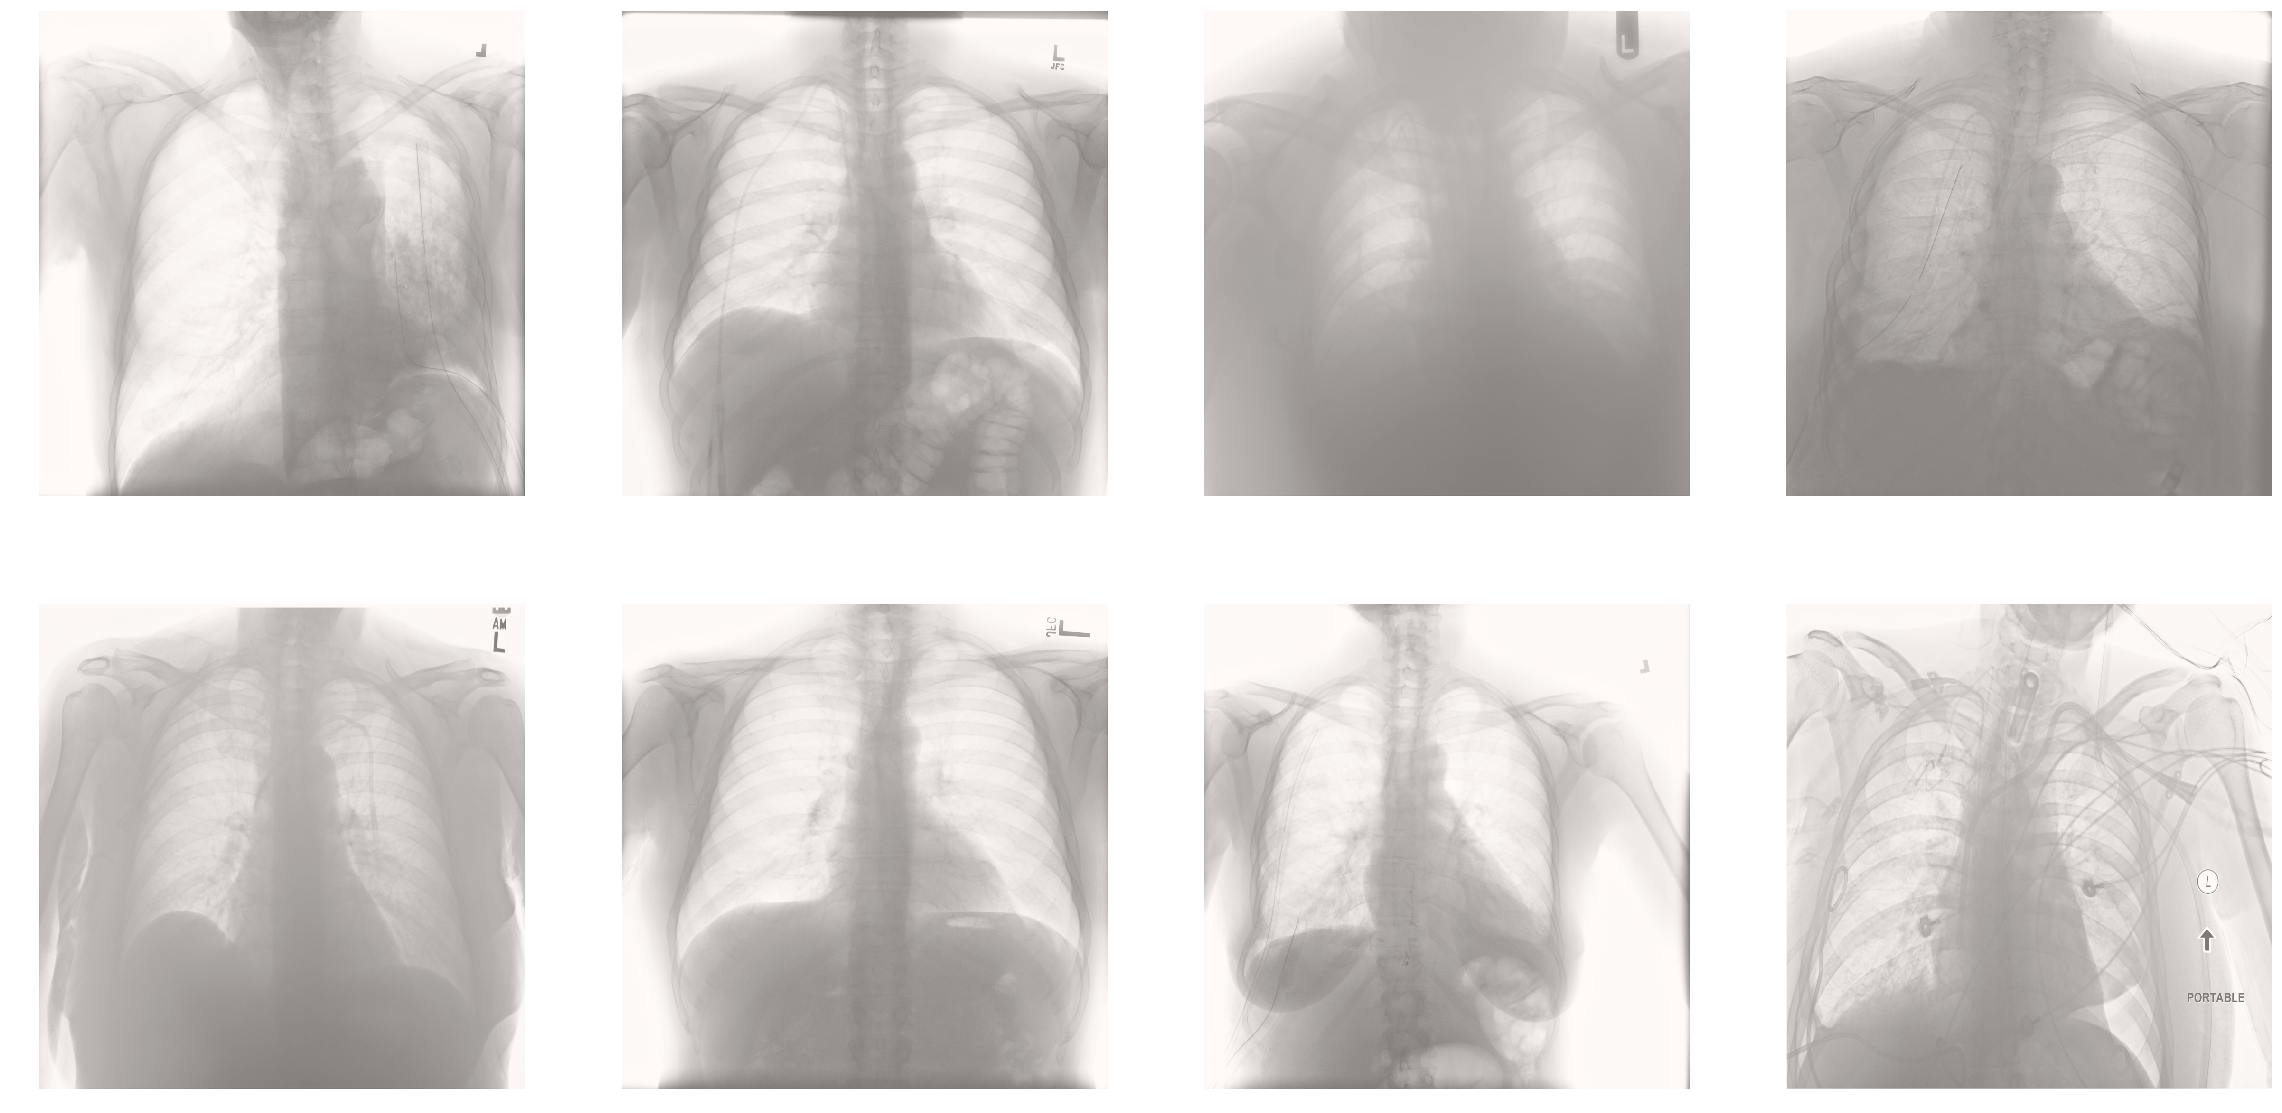

In [54]:
# Visualize
plt.clf()
threshold_best = 0.2
max_images = 8
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*10, grid_height*10))
# for i, idx in enumerate(index_val[:max_images]):
for i, idx in enumerate(test_fns[:max_images]):
    img = X_test[i].squeeze()
    pred = preds[i].squeeze()
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.5, cmap="Reds")
    ax.axis('off')
plt.show()

In [55]:
# Generate rle encodings
preds = preds.squeeze()
rles = []
i,max_img = 1,10
plt.figure(figsize=(16,4))
for im in preds:
    im = im > threshold_best
    #if im.sum() < 1024*2:
    #    im[:] = 0
    im = (im.T*255).astype(np.uint8)  
    rles.append(mask2rle(im, 1024, 1024))
    i += 1
    if i<max_img:
        plt.subplot(1,max_img,i)
        plt.imshow(im)
        plt.axis('off')

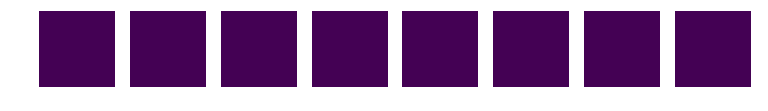

In [58]:
plt.show()

In [56]:
ids = [o.split('/')[-1][:-4] for o in test_fns]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head()

EncodedPixels                                            ImageId
0            -1  dicom-images-test\1.2.276.0.7230010.3.1.2.8323...
1            -1  dicom-images-test\1.2.276.0.7230010.3.1.2.8323...
2            -1  dicom-images-test\1.2.276.0.7230010.3.1.2.8323...
3            -1  dicom-images-test\1.2.276.0.7230010.3.1.2.8323...
4            -1  dicom-images-test\1.2.276.0.7230010.3.1.2.8323...

In [57]:
sub_df.to_csv('submission.csv', index=False)

### Submission

In [ ]:
#submission_df = pd.DataFrame(sublist, columns=sample_df.columns.values)

This isn't working as well as I'd like it to, but I'll leave it here for now. The data is loading, the model is training, I'm still hoping for clarification on the submission, as there is a mismatch between the `smaple_submission.csv` and the provided data.

Better ideas are to use proper train / validation splits, possibly with [stratification](https://en.wikipedia.org/wiki/Stratified_sampling) and consider using a nice [Generator](https://keras.io/preprocessing/image/) instead. Particularly, it may be benefitial not training on 1024x1024 images, but patches of the image. [This kernel](https://www.kaggle.com/toregil/a-lung-u-net-in-keras) might be interesting, but there are many on kaggle on lung segmentation, [mine on salt segmentation](https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics), or the [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge) challenge.

## Learnings from Other Segmentation Challenges

These are of course some learnings I gained, but they are from the amazing kagglers in all the links, so please give them the credits. (Especially [Heng CherKeng](https://www.kaggle.com/hengck23), learned a bunch from them and the list below is heavily influenced by them.)

As losses go, definitely check out [IOU / Jaccard](Intersection over union), [Lovasz](https://arxiv.org/abs/1705.08790), and [Focal methods](https://arxiv.org/abs/1708.02002), although [Dice](https://arxiv.org/abs/1707.03237) is the LB loss. You'll probably enjoy [Hypercolumns](https://arxiv.org/abs/1411.5752), [Squeeze & Excitation](https://arxiv.org/abs/1803.02579), [Data Distillation](https://arxiv.org/abs/1712.04440), maybe some [Global Attention](https://arxiv.org/abs/1805.10180) in your Upsampling, and even sprinkle in some [Stochastic Weight Averaging](https://towardsdatascience.com/stochastic-weight-averaging-a-new-way-to-get-state-of-the-art-results-in-deep-learning-c639ccf36a). Some [common tricks on kaggle image segmentation](https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63984#latest-425973) are:

- Look at the masks! (There be dragons.)
- Analyze the metadata! (There be leakage.)


- Predict empty masks (Binary Classification)
- Break down problem (Male / Female Networks? Multiclass?)
- Active learning of sorting out easy and hard to classify images (Confidence Intervals)


- Pesudo-labeling, semi-suervised learning, knowledge distillation, adversarial training
- Additional labeling or supervisory signal 
- Clustering (KNN for image patches)
